In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import calendar
import time
from datetime import datetime, timezone,timedelta
import pytz
import os
import json
import pickle
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, TimeDistributed
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from math import sqrt
#from hyperopt import hp, tpe, space_eval
#from hyperopt.fmin import fmin
pd.set_option('display.max_columns', None)
print('tensorflow version:', tf.__version__)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# if gpu_devices:
#     for gpu_device in gpu_devices:
#         print('device available:', gpu_device)
print(tf.device)

tensorflow version: 2.3.0
<function device_v2 at 0x7f65802b7510>


Используются опенсорс библиотеки.Сайкитлерн,терзорфлоу,нумпай,пандас,тензорфлоу,керас,мас. Для работы лучше использовать графические ядра CUDA для быстроты вычисления.Но на ЦПУ все будет работать, но на порядок медленнее.Инференс можно делать и на ЦПУ. Обучение и дообучение модели только на ГПУ!

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpu_devices:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [4]:
MODEL_PATH = './model'
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

def set_all_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_all_seeds(777)

Зафиксируем сиды для повторяемости результатов и вопспроизведения модели.

Загрузим данные из файла билдинг дата.В нашей работе мы будем использовать только данные этого файла.

In [5]:
df = pd.read_excel('data/building_data.xlsx')
df = df.sort_values(by='time')

Произведем очистку данных.Мы занулим значение целевой переменной в праздничные дни,выходные дни и ночьные часы с 23 до 7 утра.Время мы оставили в UTC просто в масках применили сдвиг.Мы намеренно не выкидывали данные,а зануляли для того что бы форма рядов оставалась и не менялась.Важно дать модели данные в которых 0 в выходные,праздники и ночьные часы.

In [6]:
cel_day_18 = np.array(['2018-3-17','2018-04-30','2018-05-01','2018-05-02',
              '2018-05-09','2018-06-11','2018-06-12',
              '2018-11-05','2018-12-31'])

cel_day_19 = np.array(['2019-01-01','2019-01-02','2019-01-03','2019-01-04','2019-01-05','2019-01-06','2019-01-07',
              '2019-01-08','2019-03-08','2019-05-01','2019-05-02','2019-05-03','2019-05-09','2019-05-10',
              '2019-06-12','2019-11-04'])

cel_day_20 = np.array(['2020-01-01','2020-01-02','2020-01-03','2020-01-04','2020-01-05','2020-01-06','2020-01-07',
              '2020-01-08','2020-02-24','2020-03-09','2020-04-22','2020-05-04','2020-05-05','2020-05-11',
              '2020-06-12','2020-11-04']) 

cel_day_21 = np.array(['2021-01-01','2021-01-04','2021-01-05','2021-01-06','2021-01-07','2021-01-08','2021-02-22',
              '2021-02-23','2021-03-08','2021-05-03','2021-05-10','2021-06-14','2021-11-04','2021-11-05',
              '2021-12-31'])

df['Target_Sum'] = df['_Consumers_Bus_4_p_TM1H_mv_val'] + df['_Consumers_Bus_3_p_TM1H_mv_val'] +\
                            df['_Consumers_Bus_2_p_TM1H_mv_val'] + df['_Consumers_Bus_1_p_TM1H_mv_val']


mask_da_1 = np.array((df['time'].dt.hour >= 4) & (df['time'].dt.hour <= 19))
mask_da_2 = np.array((df['time'].dt.weekday < 5 ))
mask_da_3 = ~np.in1d(df.time.dt.date, pd.to_datetime(cel_day_18).date)
mask_da_4 = ~np.in1d(df.time.dt.date, pd.to_datetime(cel_day_19).date)
mask_da_5 = ~np.in1d(df.time.dt.date, pd.to_datetime(cel_day_20).date)
mask_da_6 = ~np.in1d(df.time.dt.date, pd.to_datetime(cel_day_21).date)

df['Target_Sum'] = np.where(mask_da_1&mask_da_2&mask_da_3&mask_da_4&mask_da_5,df['Target_Sum'],0)

df['_externalGrid_Bus_1_p_TM1H_mv_val'] = np.where(mask_da_1&mask_da_2&mask_da_3&mask_da_4&mask_da_5,df['_externalGrid_Bus_1_p_TM1H_mv_val'],0)
df['_externalGrid_Bus_2_p_TM1H_mv_val'] = np.where(mask_da_1&mask_da_2&mask_da_3&mask_da_4&mask_da_5,df['_externalGrid_Bus_2_p_TM1H_mv_val'],0)
df['_externalGrid_Bus_3_p_TM1H_mv_val'] = np.where(mask_da_1&mask_da_2&mask_da_3&mask_da_4&mask_da_5,df['_externalGrid_Bus_3_p_TM1H_mv_val'],0)
df['_externalGrid_Bus_4_p_TM1H_mv_val'] = np.where(mask_da_1&mask_da_2&mask_da_3&mask_da_4&mask_da_5,df['_externalGrid_Bus_4_p_TM1H_mv_val'],0)

df['_roof_1_Bus_4_p_TM1H_mv_val'] = np.where(mask_da_1&mask_da_2&mask_da_3&mask_da_4&mask_da_5,df['_roof_1_Bus_4_p_TM1H_mv_val'],0)
df['_roof_2_Bus_4_p_TM1H_mv_val'] = np.where(mask_da_1&mask_da_2&mask_da_3&mask_da_4&mask_da_5,df['_roof_2_Bus_4_p_TM1H_mv_val'],0)
df['_roof_Bus_1_p_TM1H_mv_val'] = np.where(mask_da_1&mask_da_2&mask_da_3&mask_da_4&mask_da_5,df['_roof_Bus_1_p_TM1H_mv_val'],0)

df['_Accumulator_Bus_1_p_TM1H_mv_val'] = np.where(mask_da_1&mask_da_2&mask_da_3&mask_da_4&mask_da_5,df['_Accumulator_Bus_1_p_TM1H_mv_val'],0)
df['_Accumulator_Bus_2_p_TM1H_mv_val'] = np.where(mask_da_1&mask_da_2&mask_da_3&mask_da_4&mask_da_5,df['_Accumulator_Bus_2_p_TM1H_mv_val'],0)
df['_Accumulator_Bus_3_p_TM1H_mv_val'] = np.where(mask_da_1&mask_da_2&mask_da_3&mask_da_4&mask_da_5,df['_Accumulator_Bus_3_p_TM1H_mv_val'],0)

print('df shape is ', df.shape)

df shape is  (21182, 154)


Изначально в нашей датабазе было 21100 значений.Мы постараемся оставить это значение с наименьшими изменениями.Наша основня задача не сломать структуру данных во врменном ряде энерого потребления.


In [8]:
target_name_columns = ['_Consumers_Bus_1_p_TM1H_mv_qual', 
                       '_Consumers_Bus_2_p_TM1H_mv_qual',
                       '_Consumers_Bus_3_p_TM1H_mv_qual',
                       '_Consumers_Bus_4_p_TM1H_mv_qual']

target_val_columns = ['_Consumers_Bus_1_p_TM1H_mv_val',
                      '_Consumers_Bus_2_p_TM1H_mv_val',
                      '_Consumers_Bus_3_p_TM1H_mv_val',
                      '_Consumers_Bus_4_p_TM1H_mv_val']

В качестве целевой переменной мы использовали сумму активных нагрузок по четырем вводам.Далее мы посмотрим сколько значений по вводам имеют не валидное значение.

In [9]:
def target_stats(data, data_list):
    for col in data_list:
        print('Value_Counts')
        print(data[col].value_counts())   

In [10]:
target_stats(df, target_name_columns)

Value_Counts
                GOOD MEAN    20689
             INVALID MEAN      222
             GOOD DERIVED      141
Name: _Consumers_Bus_1_p_TM1H_mv_qual, dtype: int64
Value_Counts
                GOOD MEAN    20772
             GOOD DERIVED      141
             INVALID MEAN       79
Name: _Consumers_Bus_2_p_TM1H_mv_qual, dtype: int64
Value_Counts
                GOOD MEAN    20134
             INVALID MEAN      763
             GOOD DERIVED      140
Name: _Consumers_Bus_3_p_TM1H_mv_qual, dtype: int64
Value_Counts
                GOOD MEAN    20373
             INVALID MEAN      465
             GOOD DERIVED      140
          INVALID DERIVED        6
Name: _Consumers_Bus_4_p_TM1H_mv_qual, dtype: int64


Было принято решение заменить невалидные значения средним значением предыдущего периода. После этго мы смотрим на результат.

In [12]:
def fill_target_nan_past_mean(data, target_list, value):
    for col in target_list:
        time_values = data[data[col] == value]['time'].tolist()
        for t in time_values:
            mean = data[(data['time'] < t) & (data['time'].dt.hour == t.hour)][col[:-4]+'val'].mean()
            data.loc[data[data['time'] == t].index, col[:-4]+'val'] = mean
            data.loc[data[data['time'] == t].index, col] = '             REPAIRED MEAN'
        print('Done with {}'.format(col))

In [13]:
fill_target_nan_past_mean(df, target_name_columns, '             INVALID MEAN')
fill_target_nan_past_mean(df, ['_Consumers_Bus_4_p_TM1H_mv_qual'], '          INVALID DERIVED')
target_stats(df, target_name_columns)

Done with _Consumers_Bus_1_p_TM1H_mv_qual
Done with _Consumers_Bus_2_p_TM1H_mv_qual
Done with _Consumers_Bus_3_p_TM1H_mv_qual
Done with _Consumers_Bus_4_p_TM1H_mv_qual
Done with _Consumers_Bus_4_p_TM1H_mv_qual
Value_Counts
                GOOD MEAN     20689
             REPAIRED MEAN      222
             GOOD DERIVED       141
Name: _Consumers_Bus_1_p_TM1H_mv_qual, dtype: int64
Value_Counts
                GOOD MEAN     20772
             GOOD DERIVED       141
             REPAIRED MEAN       79
Name: _Consumers_Bus_2_p_TM1H_mv_qual, dtype: int64
Value_Counts
                GOOD MEAN     20134
             REPAIRED MEAN      763
             GOOD DERIVED       140
Name: _Consumers_Bus_3_p_TM1H_mv_qual, dtype: int64
Value_Counts
                GOOD MEAN     20373
             REPAIRED MEAN      471
             GOOD DERIVED       140
Name: _Consumers_Bus_4_p_TM1H_mv_qual, dtype: int64


In [14]:
df.isnull().sum()

time                                            0
_Accumulator_Bus_1_e_TM1H_mv_val            10382
_Accumulator_Bus_1_e_TM1H_mv_qual           10382
_Accumulator_Bus_1_p_TM1H_mv_qual              39
_Accumulator_Bus_1_p_TM1H_mv_val               11
                                            ...  
_unctrl_load_Bus_4_phaseB_p_TM1H_mv_val     10382
_unctrl_load_Bus_4_phaseB_p_TM1H_mv_qual    10382
_unctrl_load_Bus_4_phaseC_p_TM1H_mv_val     10382
_unctrl_load_Bus_4_phaseC_p_TM1H_mv_qual    10382
Target_Sum                                    146
Length: 154, dtype: int64

Выведем основные математрические статистики активной нагрузки по вводам для понимания о выбросах и не верных значениях.Что бы посмотртеть распределение - для четкого понимания что надо сделать при препроцессинге данных.

In [15]:
def target_math_stats(df, data_list):
    for col in data_list:
        print('Mean,Median,Min,Max,STD')
        print(df[col].name)
        print('{}_MEAN'.format(df[col].mean()))
        print('{}_MEDIAN'.format(df[col].median()))
        print('{}_MIN'.format(df[col].min()))
        print('{}_MAX'.format(df[col].max()))
        print('{}_STD'.format(df[col].std()))
        print('*'*20)

In [16]:
target_math_stats(df, target_val_columns)

Mean,Median,Min,Max,STD
_Consumers_Bus_1_p_TM1H_mv_val
8.11030039377048_MEAN
13.225975795785585_MEDIAN
-166398.6484466167_MIN
62.40810735270622_MAX
1158.7191970916626_STD
********************
Mean,Median,Min,Max,STD
_Consumers_Bus_2_p_TM1H_mv_val
19.665205755140544_MEAN
13.284164799279635_MEDIAN
9.223875578476322_MIN
61.99750408705076_MAX
10.722868373693181_STD
********************
Mean,Median,Min,Max,STD
_Consumers_Bus_3_p_TM1H_mv_val
18.11464068522177_MEAN
22.36427005310853_MEDIAN
-152079.0160299742_MIN
59.54736522620286_MAX
1048.936174598943_STD
********************
Mean,Median,Min,Max,STD
_Consumers_Bus_4_p_TM1H_mv_val
14.245635775948909_MEAN
10.976390091271865_MEDIAN
6.459926748714513_MIN
51.38907291319635_MAX
6.704444701600537_STD
********************


Мы видим,что есть недопустимые отрицательные значения.Удалим их заменив на ноль и проверим как изменились статистики.

In [17]:
print(df.shape)
print('***')
for col in target_val_columns:
      df[col] = df[col].clip(lower=0)

print(df.shape)


(21182, 154)
***
(21182, 154)
(21182, 154)
(21182, 154)
(21182, 154)


In [18]:
target_math_stats(df, target_val_columns)

Mean,Median,Min,Max,STD
_Consumers_Bus_1_p_TM1H_mv_val
19.105443809695874_MEAN
13.225975795785585_MEDIAN
0.0_MIN
62.40810735270622_MAX
11.750758609338547_STD
********************
Mean,Median,Min,Max,STD
_Consumers_Bus_2_p_TM1H_mv_val
19.665205755140544_MEAN
13.284164799279635_MEDIAN
9.223875578476322_MIN
61.99750408705076_MAX
10.722868373693181_STD
********************
Mean,Median,Min,Max,STD
_Consumers_Bus_3_p_TM1H_mv_val
26.09397226370687_MEAN
22.36427005310853_MEDIAN
0.0_MIN
59.54736522620286_MAX
9.026728345794934_STD
********************
Mean,Median,Min,Max,STD
_Consumers_Bus_4_p_TM1H_mv_val
14.245635775948909_MEAN
10.976390091271865_MEDIAN
6.459926748714513_MIN
51.38907291319635_MAX
6.704444701600537_STD
********************


In [19]:
# for col in target_val_columns:    
#     #col1 = np.array(df[col].dropna())
#     col1 = np.array(df[col].fillna(0,inplace=True))
#     print(col)
#     print('Max value is ', col1.max())
#     #print('99 percentile is ', np.percentile(col1, 99))
#     #df.loc[df[col] > np.percentile(col1, 99), col] = np.percentile(col1, 99)
#     #print('Maximum values in {} are replaced with {}'.format(col, np.percentile(col1, 99)))
#     #print('Min value is ', col1.min())
#     #print('1 percentile is ', np.percentile(col1, 1))
#     #df.loc[df[col] < np.percentile(col1, 1), col] = np.percentile(col1, 1)
#     #print('Minimum values in {} are replaced with {}'.format(col, np.percentile(col1, 1)))
#     #print('-'*20)

Заменим значения средним по предыдущему промежутку.

In [20]:
def fill_target(data, target_list):
    for col in target_list:
        time_values = data[data[col[:-4]+'val'].isnull()]['time'].tolist()
        for t in time_values:
            mean = data[(data['time'] < t) & (data['time'].dt.hour == t.hour)][col[:-4]+'val'].mean()
            data.loc[data[data['time'] == t].index, col[:-4]+'val'] = mean
            data.loc[data[data['time'] == t].index, col] = '             FILLED MEAN'
        print('Done with {}'.format(col))

In [21]:
fill_target(df, target_name_columns)

Done with _Consumers_Bus_1_p_TM1H_mv_qual
Done with _Consumers_Bus_2_p_TM1H_mv_qual
Done with _Consumers_Bus_3_p_TM1H_mv_qual
Done with _Consumers_Bus_4_p_TM1H_mv_qual


In [22]:
target_stats(df, target_name_columns)

Value_Counts
                GOOD MEAN     20689
             REPAIRED MEAN      222
             GOOD DERIVED       141
             FILLED MEAN        130
Name: _Consumers_Bus_1_p_TM1H_mv_qual, dtype: int64
Value_Counts
                GOOD MEAN     20772
             FILLED MEAN        190
             GOOD DERIVED       141
             REPAIRED MEAN       79
Name: _Consumers_Bus_2_p_TM1H_mv_qual, dtype: int64
Value_Counts
                GOOD MEAN     20134
             REPAIRED MEAN      763
             FILLED MEAN        145
             GOOD DERIVED       140
Name: _Consumers_Bus_3_p_TM1H_mv_qual, dtype: int64
Value_Counts
                GOOD MEAN     20373
             REPAIRED MEAN      471
             FILLED MEAN        198
             GOOD DERIVED       140
Name: _Consumers_Bus_4_p_TM1H_mv_qual, dtype: int64


До этого мы смотрели статистики по каждому вводу.Для предотвращения ошибок посмотрим, нет ли ошибок в целевой переменной.В начале мы получили целевую переменную путес сложения не очищенных данных по четырем вводам.Как мы видим в таргете у нас большой выброс.Избавимся от него сложив уже почищенные данные по каждому входу в здание. Кроме того мы еще раз применили зануляющие маски для подстаховки.

In [23]:
sum_col = ['Target_Sum']
target_math_stats(df, sum_col)


Mean,Median,Min,Max,STD
Target_Sum
33.86591635071555_MEAN
0.0_MEDIAN
-318415.82299142925_MIN
216.39196566774422_MAX
2196.497876236233_STD
********************


In [24]:
df['Target_Sum'] = df['_Consumers_Bus_4_p_TM1H_mv_val'] + df['_Consumers_Bus_3_p_TM1H_mv_val'] +\
                            df['_Consumers_Bus_2_p_TM1H_mv_val'] + df['_Consumers_Bus_1_p_TM1H_mv_val']
df['Target_Sum'] = np.where(mask_da_1&mask_da_2&mask_da_3&mask_da_4&mask_da_5,df['Target_Sum'],0)

Как мы видим виброс по минимуму резко ушел и статистики разброса стали более правильными.

In [25]:
sum_col = ['Target_Sum']
target_math_stats(df, sum_col)

Mean,Median,Min,Max,STD
Target_Sum
50.145015196677235_MEAN
0.0_MEDIAN
0.0_MIN
216.39196566774422_MAX
58.60528064843232_STD
********************


Построим график суммарной активной мощности по входам в здание как сумму четырех входов.

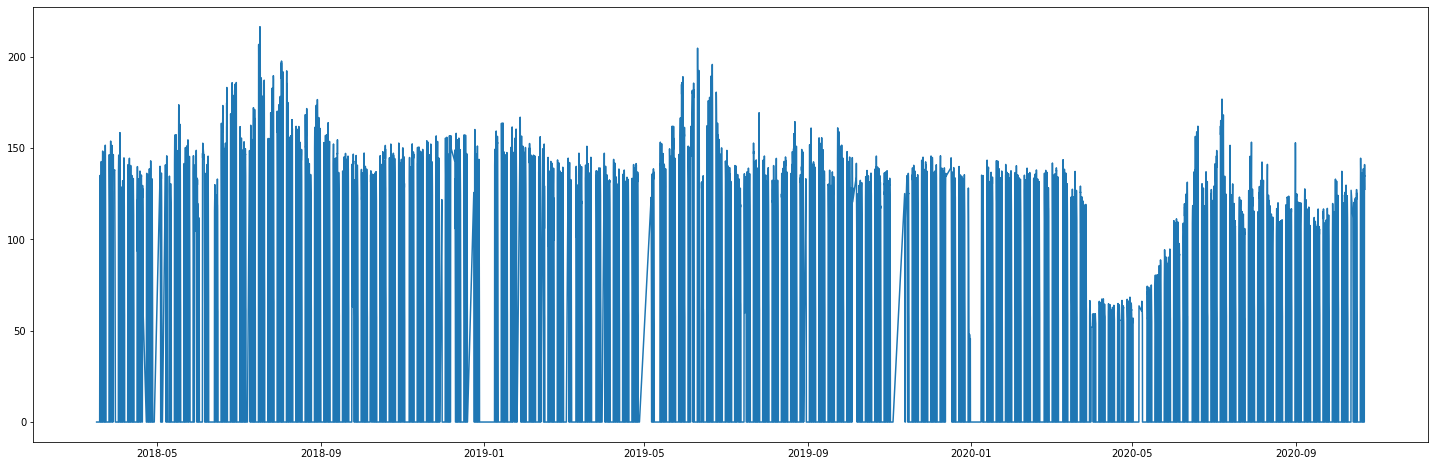

In [26]:
fig = plt.figure(figsize=(25, 8))
x = df.loc[df['Target_Sum'].dropna().index, 'time']
y = df['Target_Sum'].dropna()
plt.plot(x, y)
plt.show()

Далее получим целевую переменную путем сложения потребителей и крыши минус аккумуляторы.Четвертый аккумулятори принят за ноль.

In [27]:
complex_target = ['_externalGrid_Bus_1_p_TM1H_mv_val', '_externalGrid_Bus_2_p_TM1H_mv_val', 
                  '_externalGrid_Bus_3_p_TM1H_mv_val', '_externalGrid_Bus_4_p_TM1H_mv_val']

roof = ['_roof_1_Bus_4_p_TM1H_mv_val', '_roof_2_Bus_4_p_TM1H_mv_val',
                 '_roof_Bus_1_p_TM1H_mv_val']
accum = ['_Accumulator_Bus_1_p_TM1H_mv_val',
                 '_Accumulator_Bus_2_p_TM1H_mv_val', '_Accumulator_Bus_3_p_TM1H_mv_val']

Для проверки выбросов мы посмотрим основные мат статистики перменных.

In [28]:
target_math_stats(df, complex_target)

Mean,Median,Min,Max,STD
_externalGrid_Bus_1_p_TM1H_mv_val
13.52673452155634_MEAN
0.0_MEDIAN
0.0_MIN
72.08061322021484_MAX
16.550104871370273_STD
********************
Mean,Median,Min,Max,STD
_externalGrid_Bus_2_p_TM1H_mv_val
13.02230791180268_MEAN
0.0_MEDIAN
0.0_MIN
64.66403633223639_MAX
15.800491497544357_STD
********************
Mean,Median,Min,Max,STD
_externalGrid_Bus_3_p_TM1H_mv_val
14.222391550765352_MEAN
0.0_MEDIAN
0.0_MIN
68.85166162702772_MAX
17.44718564773237_STD
********************
Mean,Median,Min,Max,STD
_externalGrid_Bus_4_p_TM1H_mv_val
9.705070357442308_MEAN
0.0_MEDIAN
0.0_MIN
51.38907291995154_MAX
12.041111950810105_STD
********************


Все нормально мы построим графики по каждому входу.

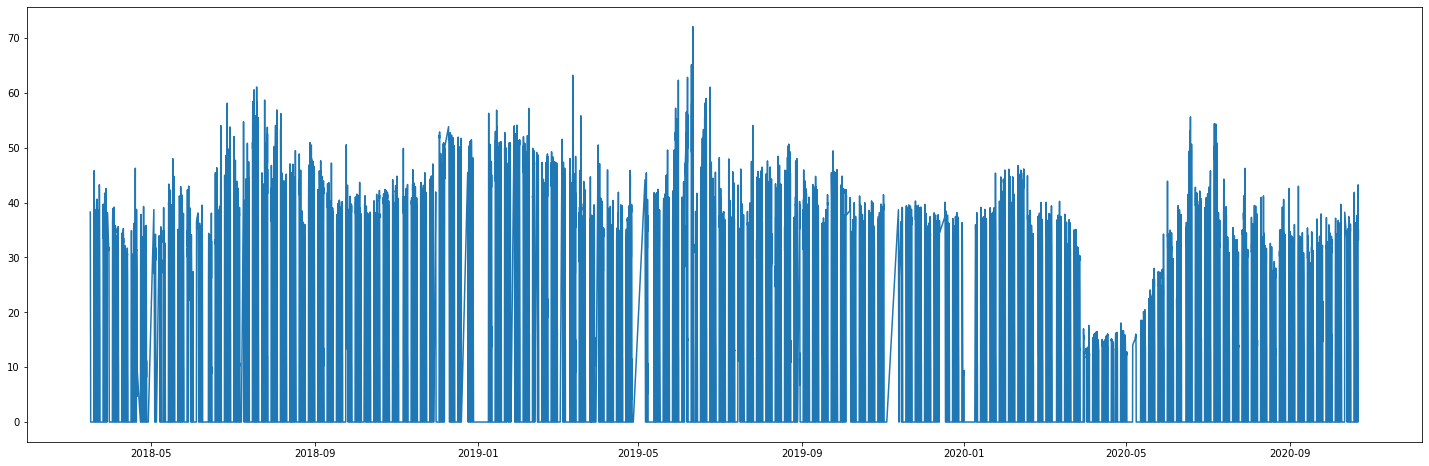

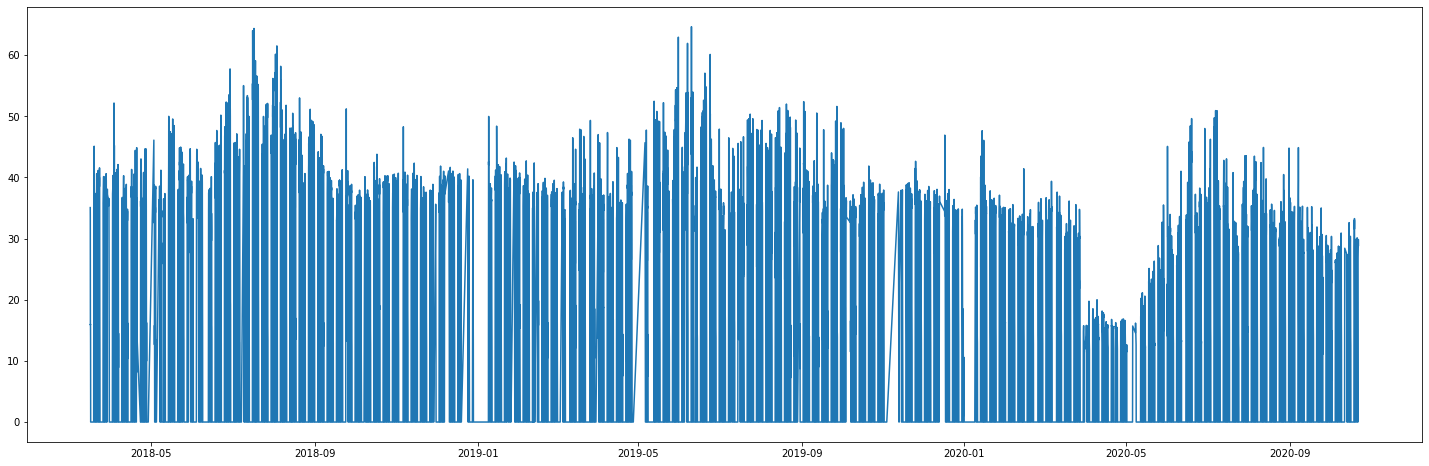

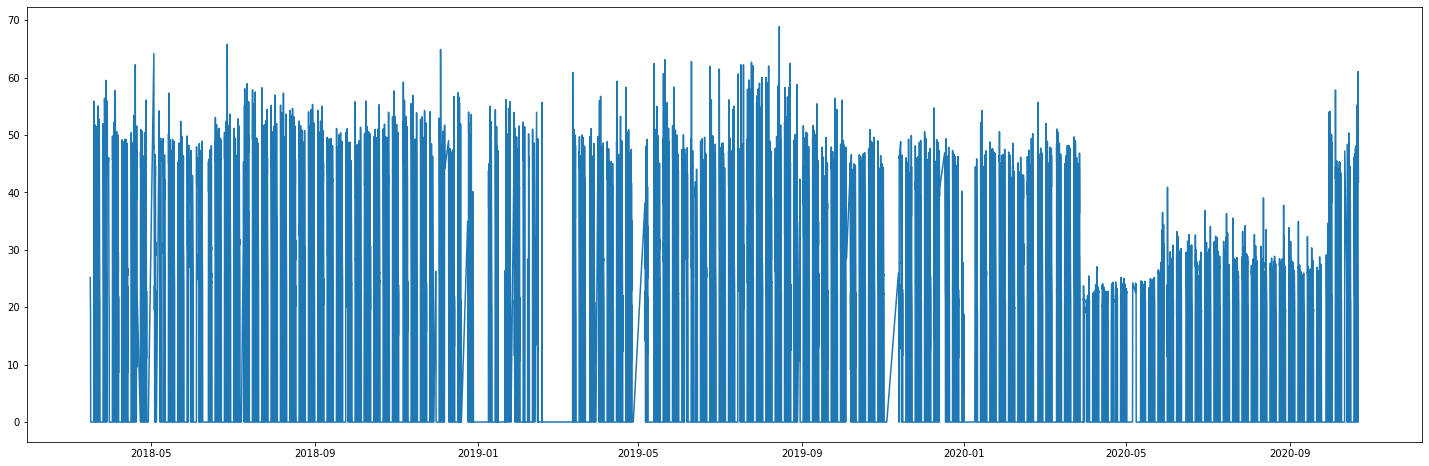

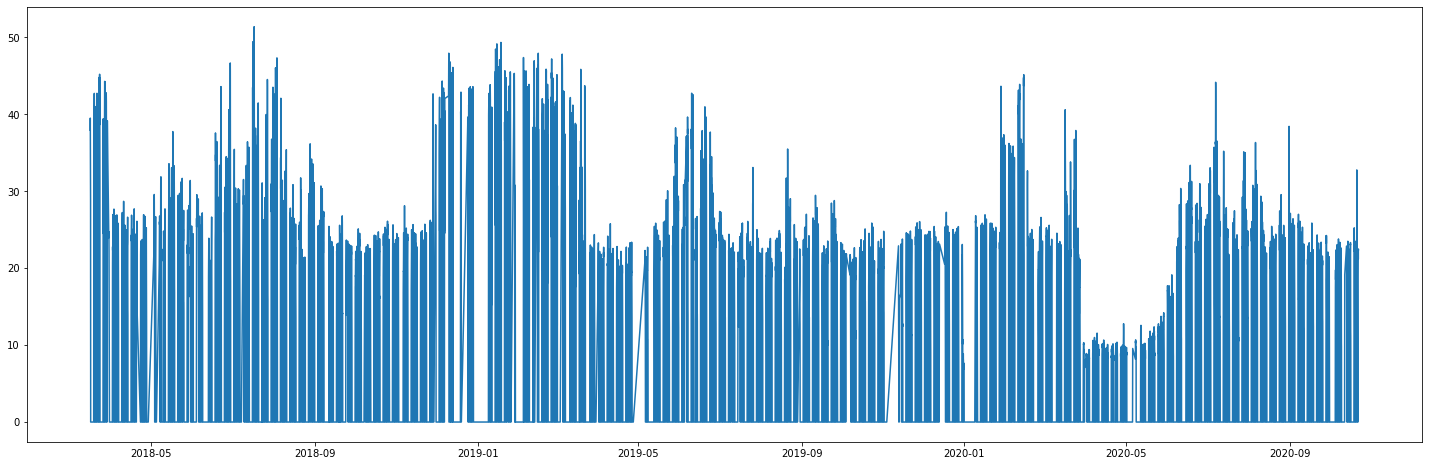

In [29]:
for col in complex_target:
    fig = plt.figure(figsize=(25, 8))
    x = df.loc[df[col].dropna().index, 'time']
    y = df[col].dropna()
    plt.plot(x, y)
    plt.show()

In [30]:
df[complex_target].isnull().sum()

_externalGrid_Bus_1_p_TM1H_mv_val    14
_externalGrid_Bus_2_p_TM1H_mv_val    52
_externalGrid_Bus_3_p_TM1H_mv_val    42
_externalGrid_Bus_4_p_TM1H_mv_val    54
dtype: int64

In [31]:
#df.loc[df['_externalGrid_Bus_3_p_TM1H_mv_val'] < 7,'_externalGrid_Bus_3_p_TM1H_mv_val'] = np.percentile(np.array(df['_externalGrid_Bus_3_p_TM1H_mv_val'].dropna()), 4)
#df.loc[df['_externalGrid_Bus_4_p_TM1H_mv_val'] < 7,'_externalGrid_Bus_4_p_TM1H_mv_val'] = np.percentile(np.array(df['_externalGrid_Bus_4_p_TM1H_mv_val'].dropna()), 2)

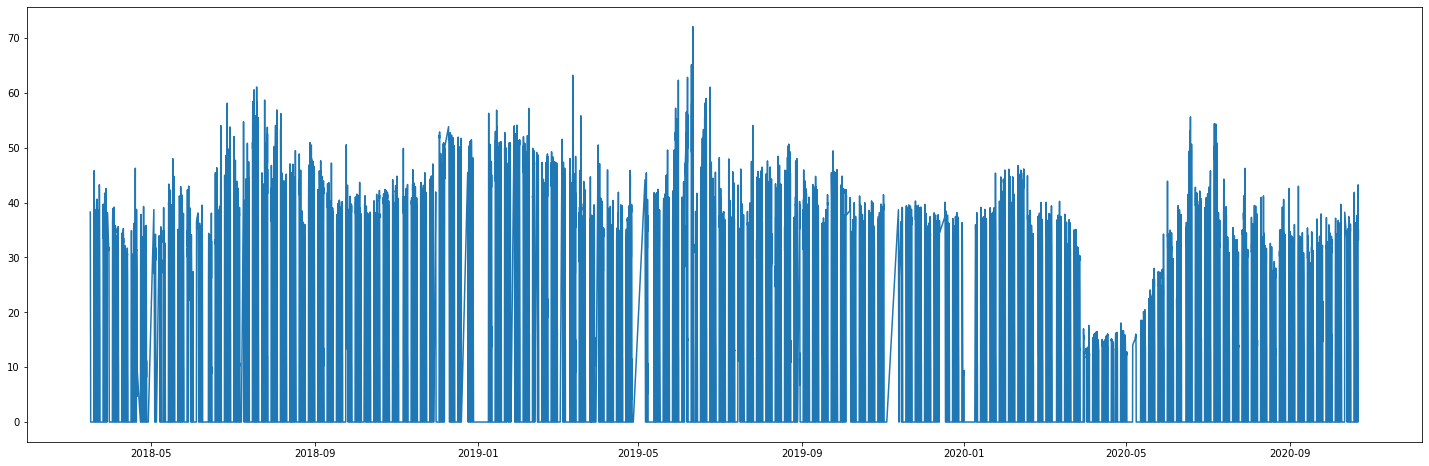

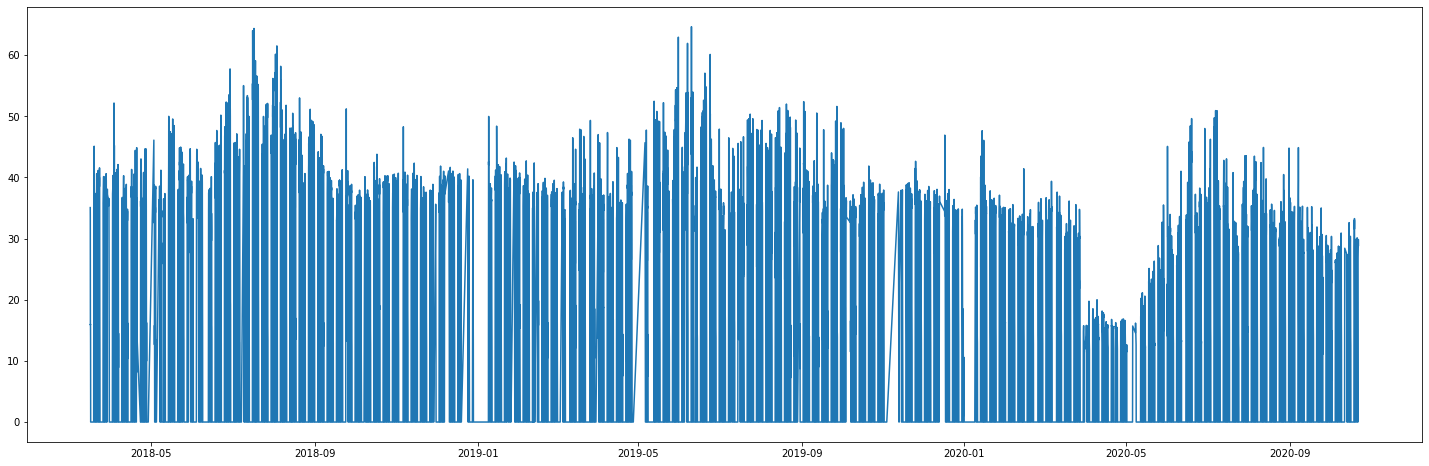

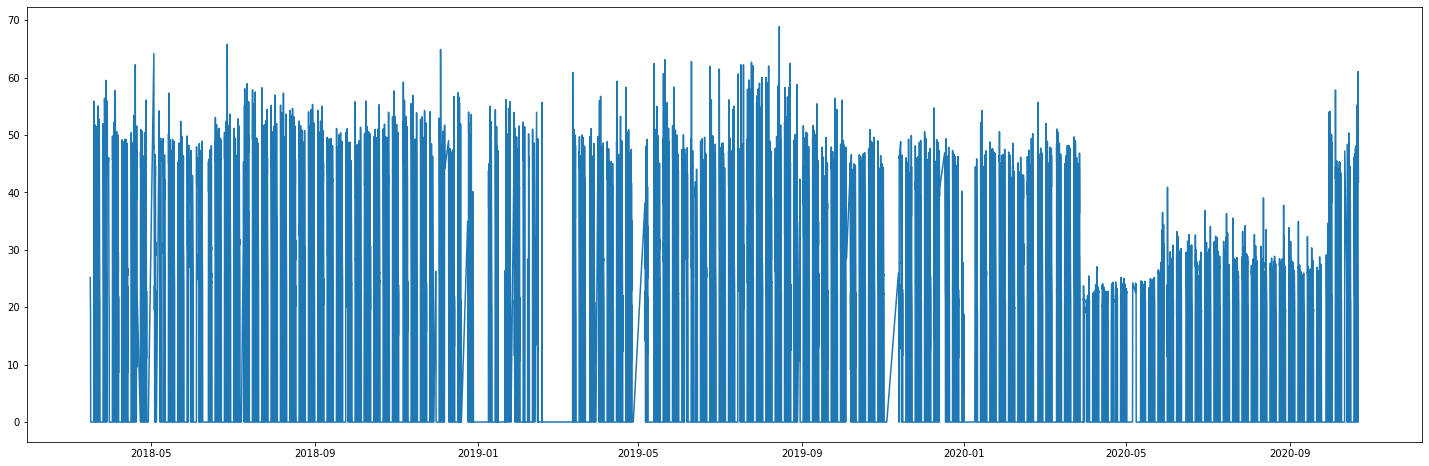

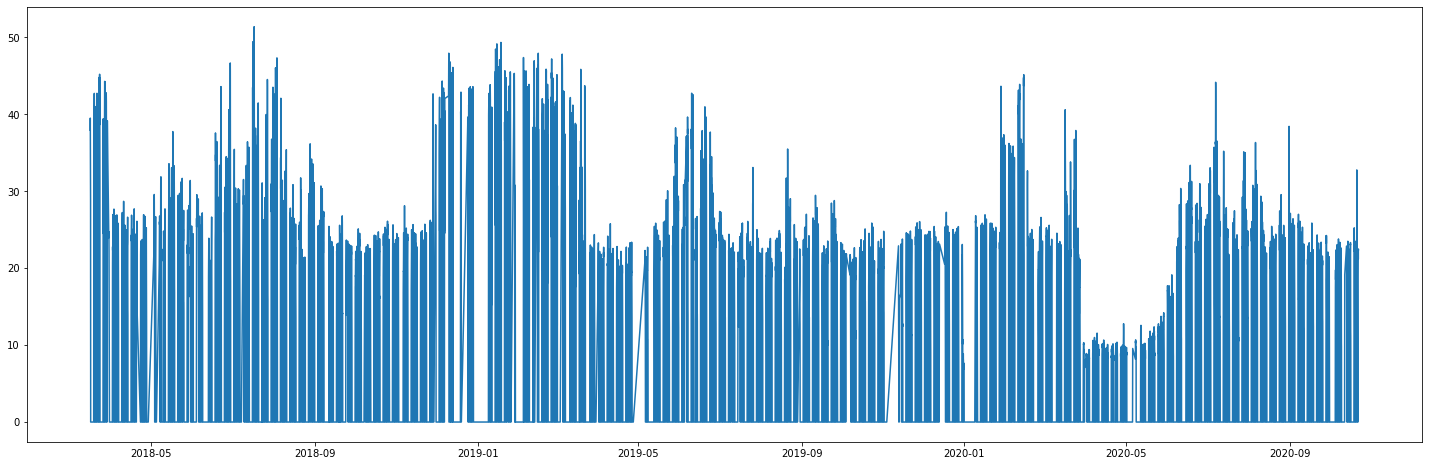

In [32]:
for col in complex_target:
    fig = plt.figure(figsize=(25, 8))
    x = df.loc[df[col].dropna().index, 'time']
    y = df[col].dropna()
    plt.plot(x, y)
    plt.show()

In [40]:
# for col in complex_target:    
#     col1 = np.array(df[col].dropna())
#     print(col)
#     print('Max value is ', col1.max())
#     print('99 percentile is ', np.percentile(col1, 99))
#     df.loc[df[col] > np.percentile(col1, 99), col] = np.percentile(col1, 99)
#     print('Maximum values in {} are replaced with {}'.format(col, np.percentile(col1, 99)))
#     print('Min value is ', col1.min())
#     print('1 percentile is ', np.percentile(col1, 1))
#     df.loc[df[col] < np.percentile(col1, 1), col] = np.percentile(col1, 1)
#     print('Minimum values in {} are replaced with {}'.format(col, np.percentile(col1, 1)))
#     print('-'*20)

In [33]:
target_math_stats(df, complex_target)

Mean,Median,Min,Max,STD
_externalGrid_Bus_1_p_TM1H_mv_val
13.52673452155634_MEAN
0.0_MEDIAN
0.0_MIN
72.08061322021484_MAX
16.550104871370273_STD
********************
Mean,Median,Min,Max,STD
_externalGrid_Bus_2_p_TM1H_mv_val
13.02230791180268_MEAN
0.0_MEDIAN
0.0_MIN
64.66403633223639_MAX
15.800491497544357_STD
********************
Mean,Median,Min,Max,STD
_externalGrid_Bus_3_p_TM1H_mv_val
14.222391550765352_MEAN
0.0_MEDIAN
0.0_MIN
68.85166162702772_MAX
17.44718564773237_STD
********************
Mean,Median,Min,Max,STD
_externalGrid_Bus_4_p_TM1H_mv_val
9.705070357442308_MEAN
0.0_MEDIAN
0.0_MIN
51.38907291995154_MAX
12.041111950810105_STD
********************


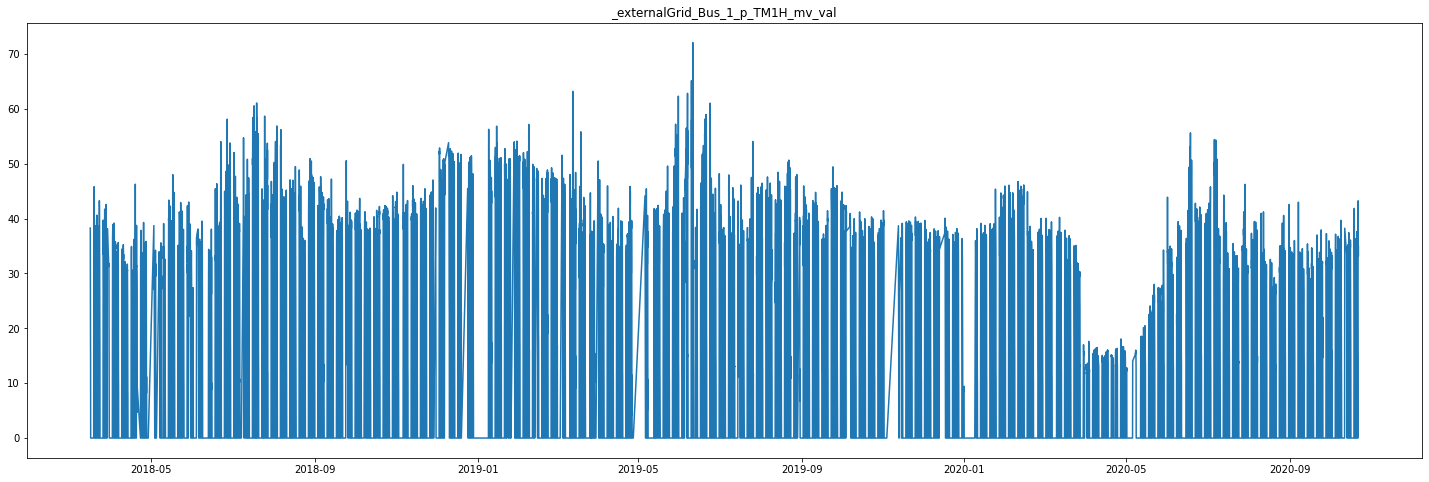

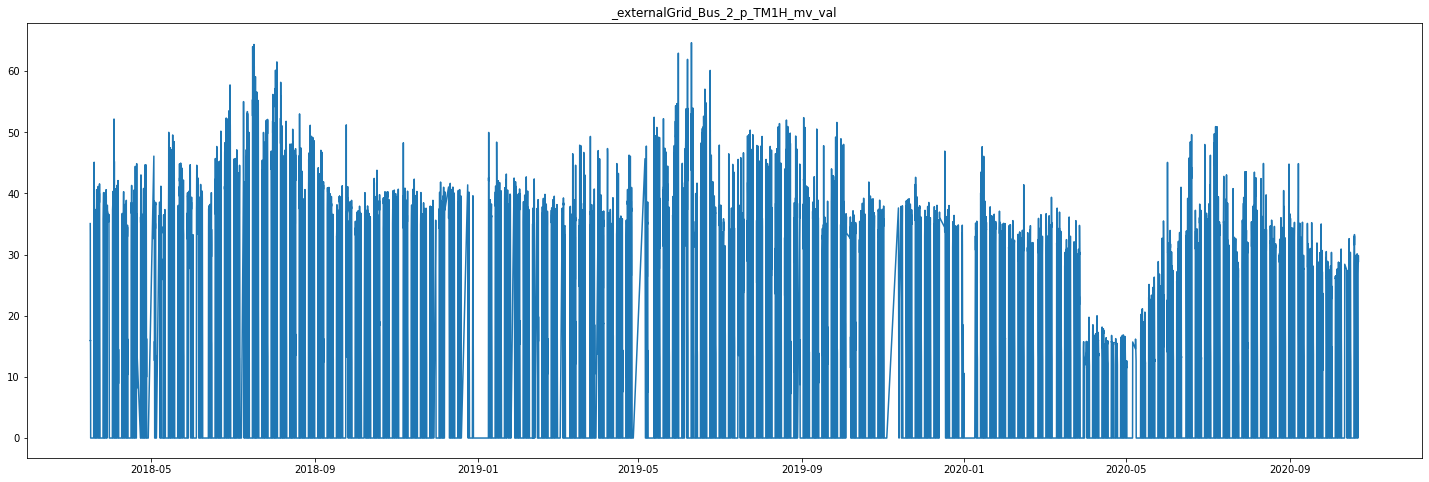

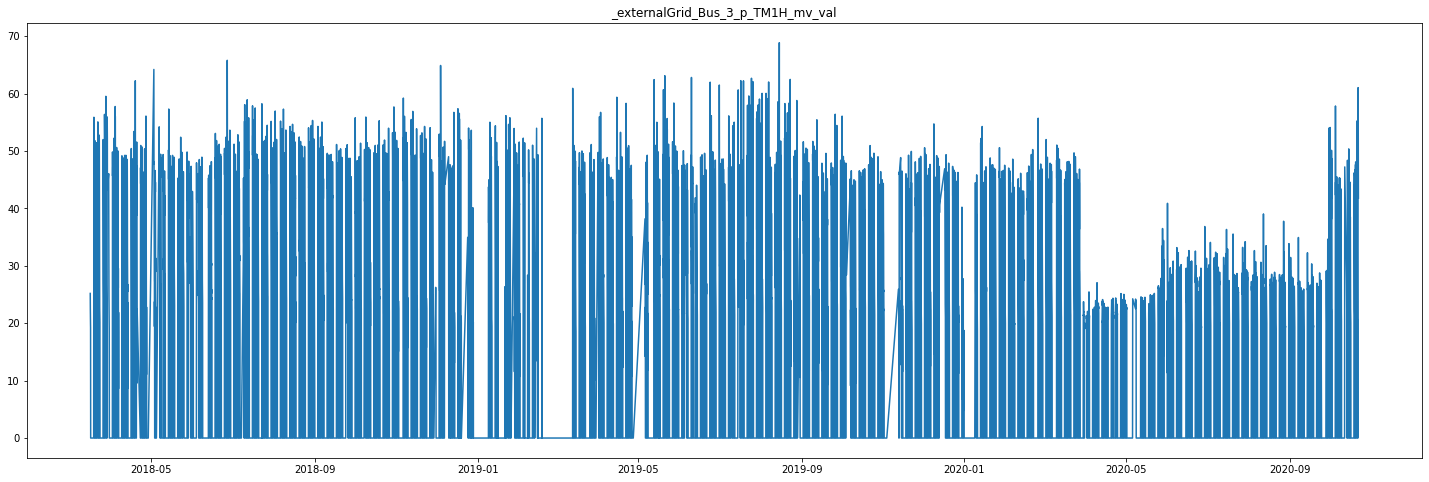

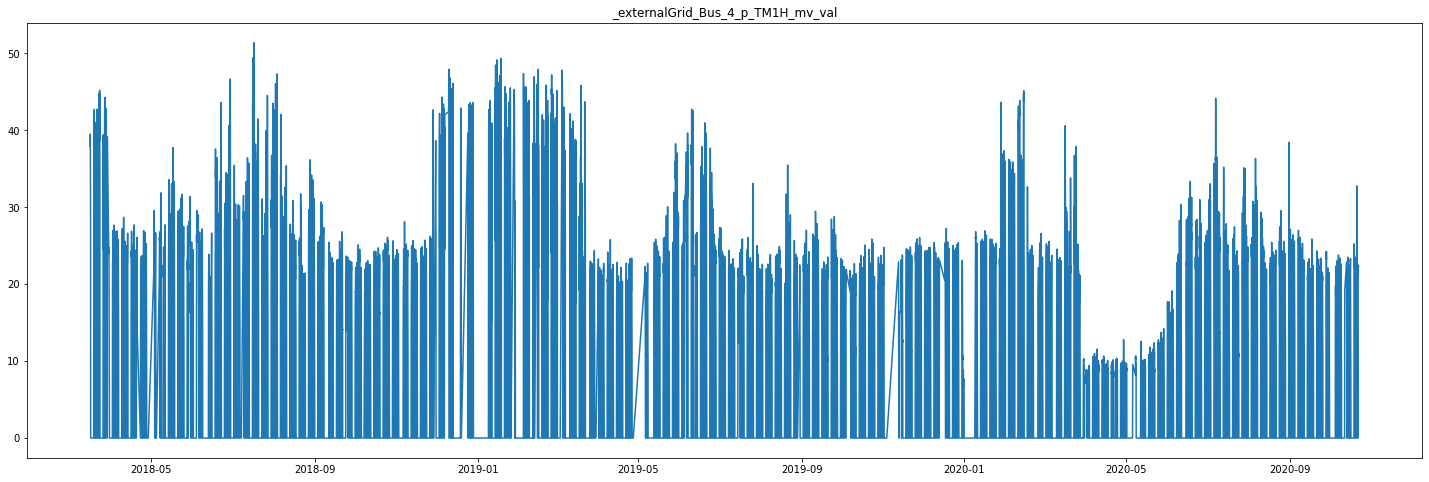

In [34]:
for col in complex_target:
    fig = plt.figure(figsize=(25, 8))
    x = df.loc[df[col].dropna().index, 'time']
    y = df[col].dropna()
    plt.title(col)
    plt.plot(x, y)
    plt.show()

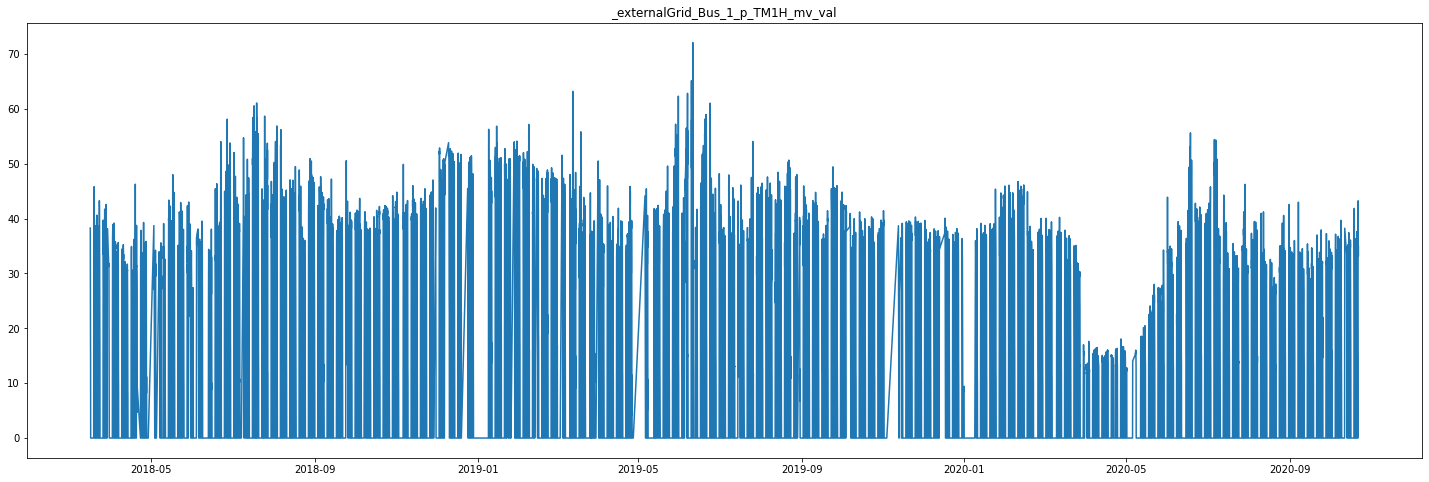

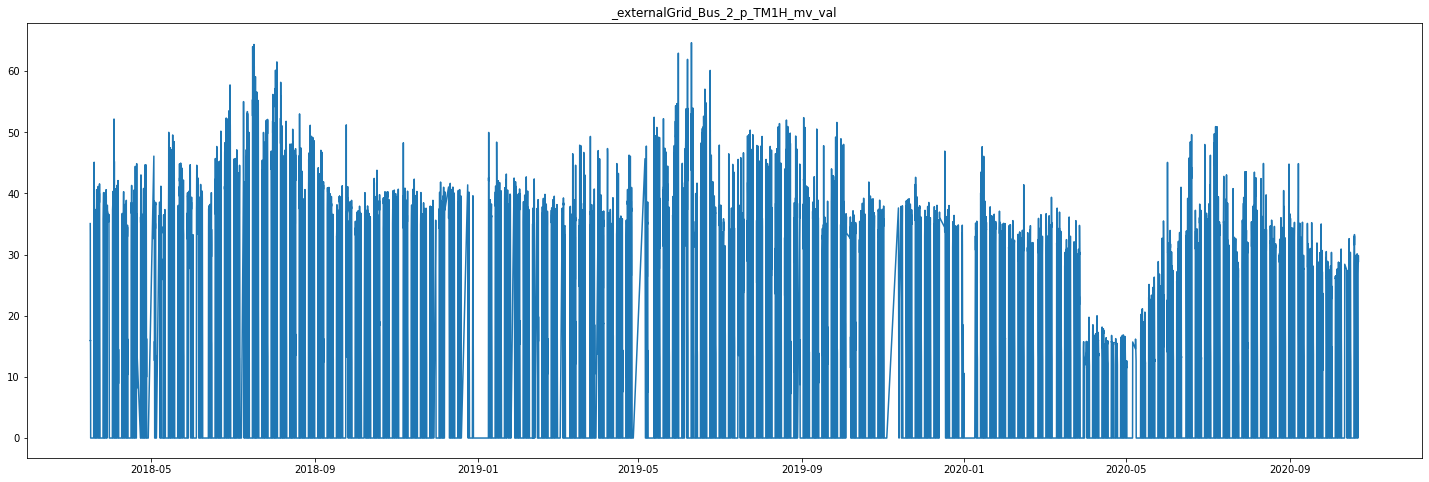

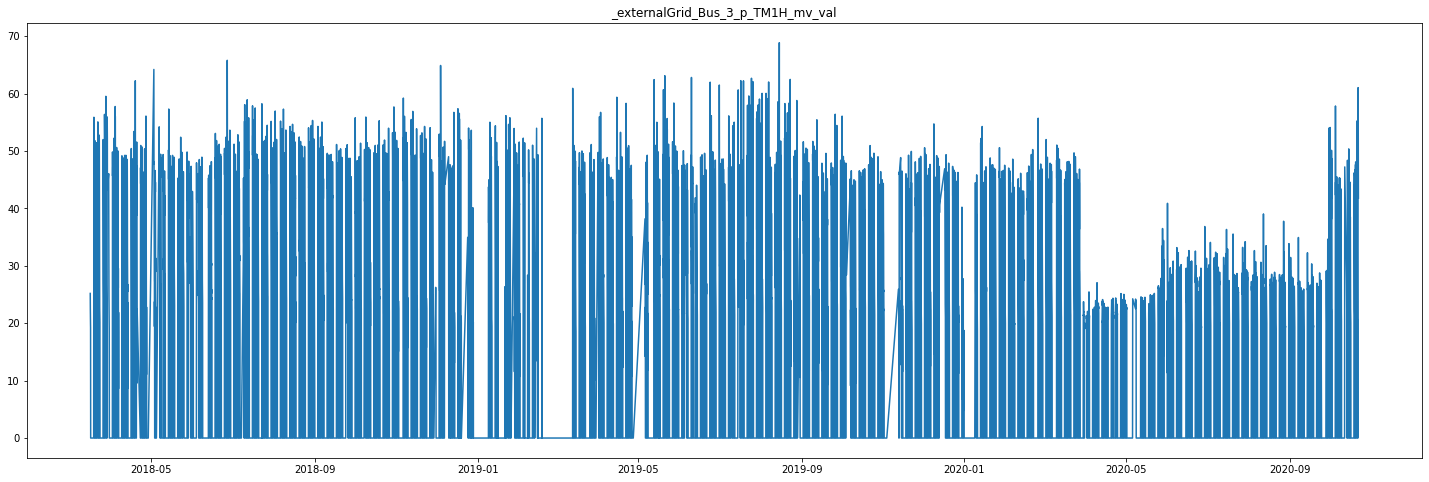

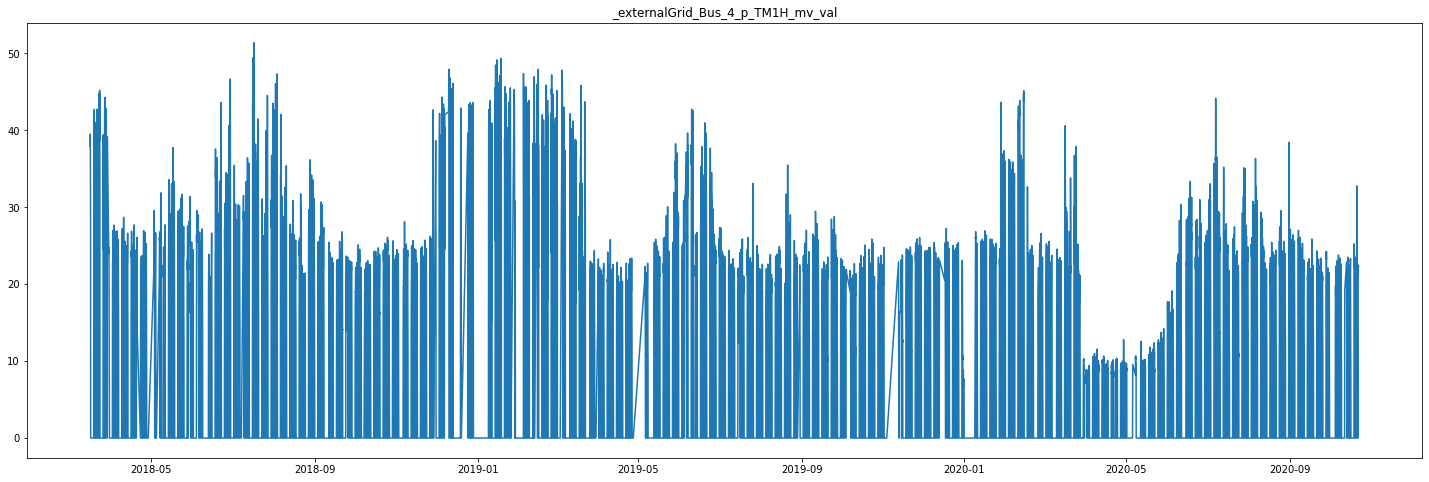

In [35]:
for col in complex_target:
    fig = plt.figure(figsize=(25, 8))
    x = df.loc[df[col].dropna().index, 'time']
    y = df[col].dropna()
    plt.title(col)
    plt.plot(x, y)
    plt.show()

In [36]:
def fill_target1(data, target_list):
    for col in target_list:
        time_values = data[data[col].isnull()]['time'].tolist()
        for t in time_values:
            mean = data[(data['time'] < t) & (data['time'].dt.hour == t.hour)][col].mean()
            data.loc[data[data['time'] == t].index, col] = mean
        print('Done with {}'.format(col))

Снова заменим данные в потребителях срединими значениями за прошлый период.

In [37]:
fill_target1(df, complex_target)
fill_target1(df, roof)
fill_target1(df, accum)

Done with _externalGrid_Bus_1_p_TM1H_mv_val
Done with _externalGrid_Bus_2_p_TM1H_mv_val
Done with _externalGrid_Bus_3_p_TM1H_mv_val
Done with _externalGrid_Bus_4_p_TM1H_mv_val
Done with _roof_1_Bus_4_p_TM1H_mv_val
Done with _roof_2_Bus_4_p_TM1H_mv_val
Done with _roof_Bus_1_p_TM1H_mv_val
Done with _Accumulator_Bus_1_p_TM1H_mv_val
Done with _Accumulator_Bus_2_p_TM1H_mv_val
Done with _Accumulator_Bus_3_p_TM1H_mv_val


In [38]:
print(df[complex_target].isnull().sum())
print(df[roof].isnull().sum())
print(df[accum].isnull().sum())

_externalGrid_Bus_1_p_TM1H_mv_val    1
_externalGrid_Bus_2_p_TM1H_mv_val    0
_externalGrid_Bus_3_p_TM1H_mv_val    0
_externalGrid_Bus_4_p_TM1H_mv_val    0
dtype: int64
_roof_1_Bus_4_p_TM1H_mv_val    0
_roof_2_Bus_4_p_TM1H_mv_val    0
_roof_Bus_1_p_TM1H_mv_val      1
dtype: int64
_Accumulator_Bus_1_p_TM1H_mv_val    1
_Accumulator_Bus_2_p_TM1H_mv_val    0
_Accumulator_Bus_3_p_TM1H_mv_val    1
dtype: int64


Проверим сколько переменных мы потеряли,для оценки состояния структуры наших данных.
Мы видим количество не помнялось и это очень хорошо.

In [39]:
print(df.shape)
for col in complex_target:
    df.drop(df[df[col].isnull()].index, axis=0, inplace=True)
    print(df.shape)
for col in roof:
    df.drop(df[df[col].isnull()].index, axis=0, inplace=True)
    print(df.shape)
for col in accum:
    df.drop(df[df[col].isnull()].index, axis=0, inplace=True)
    print(df.shape)

(21182, 154)
(21181, 154)
(21181, 154)
(21181, 154)
(21181, 154)
(21181, 154)
(21181, 154)
(21181, 154)
(21180, 154)
(21180, 154)
(21180, 154)


In [40]:
df['Target_Sum_Complex'] = (df['_externalGrid_Bus_1_p_TM1H_mv_val']+
                                      df['_externalGrid_Bus_2_p_TM1H_mv_val']+
                                      df['_externalGrid_Bus_3_p_TM1H_mv_val']+
                                      df['_externalGrid_Bus_4_p_TM1H_mv_val'])- \
                                     (df['_roof_1_Bus_4_p_TM1H_mv_val']+
                                      df['_roof_2_Bus_4_p_TM1H_mv_val']+
                                      df['_roof_Bus_1_p_TM1H_mv_val'])+ \
                                     (df['_Accumulator_Bus_1_p_TM1H_mv_val']+
                                      df['_Accumulator_Bus_2_p_TM1H_mv_val']+
                                      df['_Accumulator_Bus_3_p_TM1H_mv_val'])

Мы получим таргет перменную путем сложения нагрузки по входам и крыши минус аккумуляторы.После этого мы построим графики этих двух перемнных для понимания абсолютно ли они равны между собой.На графике мы видим, что переменная ТаргетСум(сумма по 4 рем входам) на первый взгляд в 2019 году отражала более высокую потребляемую мощность.

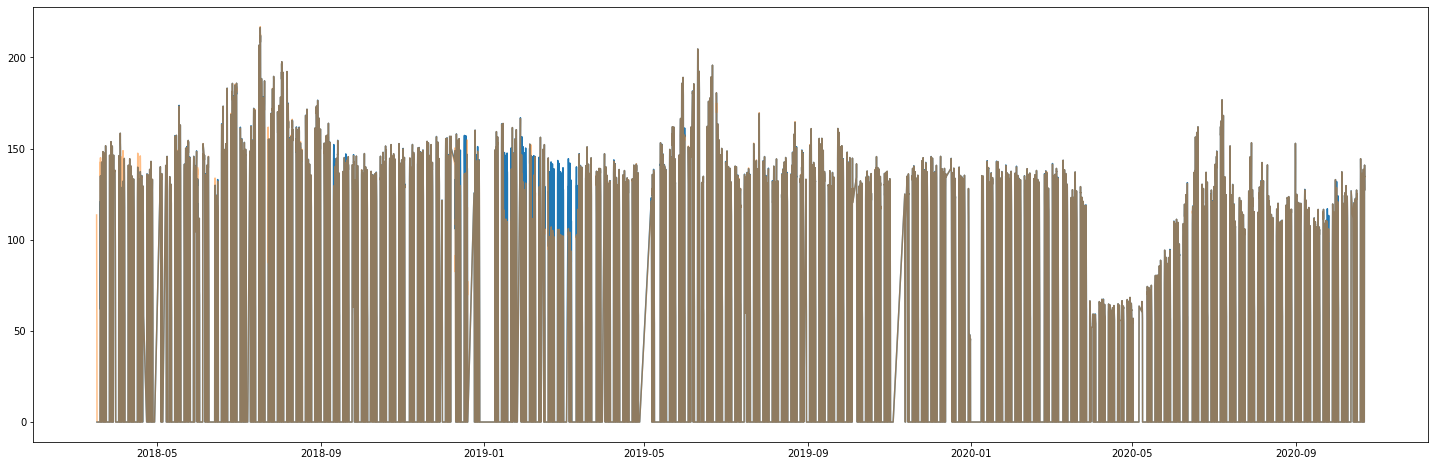

In [41]:
fig = plt.figure(figsize=(25, 8))
x = df.loc[df['Target_Sum'].dropna().index, 'time']
y = df['Target_Sum'].dropna()
plt.plot(x, y)
x = df.loc[df['Target_Sum_Complex'].dropna().index, 'time']
y = df['Target_Sum_Complex'].dropna()
plt.plot(x, y, alpha=0.5)
plt.show()

Добавим в наши данные переменные отражающие день в месяце,номер недели,месяц,номер недели в году.Эти переменные будут нашими дополнительными фичерами которыми мы обогатим наши данные.Мы считаем что есть мини сезонность от каждой из этих данных.

In [42]:
df_data_wh = df
df_data_wh['n_day'] = df_data_wh['time'].dt.day
df_data_wh['n_week'] = df_data_wh['time'].dt.week
df_data_wh['n_month'] = df_data_wh['time'].dt.month
df_data_wh['w_day'] = df_data_wh['time'].dt.weekday
#df_data_wh['is_weekend'] = (df_data_mask['w_day'] >= 5)
df_data_wh.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,time,_Accumulator_Bus_1_e_TM1H_mv_val,_Accumulator_Bus_1_e_TM1H_mv_qual,_Accumulator_Bus_1_p_TM1H_mv_qual,_Accumulator_Bus_1_p_TM1H_mv_val,_Accumulator_Bus_1_phaseA_p_TM1H_mv_val,_Accumulator_Bus_1_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_1_phaseB_p_TM1H_mv_val,_Accumulator_Bus_1_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_1_phaseC_p_TM1H_mv_val,_Accumulator_Bus_1_phaseC_p_TM1H_mv_qual,_Accumulator_Bus_2_e_TM1H_mv_val,_Accumulator_Bus_2_e_TM1H_mv_qual,_Accumulator_Bus_2_p_TM1H_mv_qual,_Accumulator_Bus_2_p_TM1H_mv_val,_Accumulator_Bus_2_phaseA_p_TM1H_mv_val,_Accumulator_Bus_2_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_2_phaseB_p_TM1H_mv_val,_Accumulator_Bus_2_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_2_phaseC_p_TM1H_mv_val,_Accumulator_Bus_2_phaseC_p_TM1H_mv_qual,_Accumulator_Bus_3_e_TM1H_mv_val,_Accumulator_Bus_3_e_TM1H_mv_qual,_Accumulator_Bus_3_p_TM1H_mv_qual,_Accumulator_Bus_3_p_TM1H_mv_val,_Accumulator_Bus_3_phaseA_p_TM1H_mv_val,_Accumulator_Bus_3_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_3_phaseB_p_TM1H_mv_val,_Accumulator_Bus_3_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_3_phaseC_p_TM1H_mv_val,_Accumulator_Bus_3_phaseC_p_TM1H_mv_qual,_Accumulator_Bus_4_e_TM1H_mv_val,_Accumulator_Bus_4_e_TM1H_mv_qual,_Accumulator_Bus_4_p_TM1H_mv_val,_Accumulator_Bus_4_p_TM1H_mv_qual,_Accumulator_Bus_4_phaseA_p_TM1H_mv_val,_Accumulator_Bus_4_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_4_phaseB_p_TM1H_mv_val,_Accumulator_Bus_4_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_4_phaseC_p_TM1H_mv_val,_Accumulator_Bus_4_phaseC_p_TM1H_mv_qual,_All_Consumers_p_TM1H_mv_val,_All_Consumers_p_TM1H_mv_qual,_Bus_1_p_TM1H_mv_val,_Bus_1_p_TM1H_mv_qual,_Bus_2_p_TM1H_mv_val,_Bus_2_p_TM1H_mv_qual,_Bus_3_p_TM1H_mv_val,_Bus_3_p_TM1H_mv_qual,_Bus_4_p_TM1H_mv_val,_Bus_4_p_TM1H_mv_qual,_Consumers_Bus_1_p_TM1H_mv_qual,_Consumers_Bus_1_p_TM1H_mv_val,_Consumers_Bus_2_p_TM1H_mv_qual,_Consumers_Bus_2_p_TM1H_mv_val,_Consumers_Bus_3_p_TM1H_mv_qual,_Consumers_Bus_3_p_TM1H_mv_val,_Consumers_Bus_4_p_TM1H_mv_qual,_Consumers_Bus_4_p_TM1H_mv_val,_externalGrid_Bus_1_p_TM1H_mv_qual,_externalGrid_Bus_1_p_TM1H_mv_val,_externalGrid_Bus_1_phaseA_p_TM1H_mv_val,_externalGrid_Bus_1_phaseA_p_TM1H_mv_qual,_externalGrid_Bus_1_phaseB_p_TM1H_mv_val,_externalGrid_Bus_1_phaseB_p_TM1H_mv_qual,_externalGrid_Bus_1_phaseC_p_TM1H_mv_val,_externalGrid_Bus_1_phaseC_p_TM1H_mv_qual,_externalGrid_Bus_2_p_TM1H_mv_qual,_externalGrid_Bus_2_p_TM1H_mv_val,_externalGrid_Bus_2_phaseA_p_TM1H_mv_val,_externalGrid_Bus_2_phaseA_p_TM1H_mv_qual,_externalGrid_Bus_2_phaseB_p_TM1H_mv_val,_externalGrid_Bus_2_phaseB_p_TM1H_mv_qual,_externalGrid_Bus_2_phaseC_p_TM1H_mv_val,_externalGrid_Bus_2_phaseC_p_TM1H_mv_qual,_externalGrid_Bus_3_p_TM1H_mv_qual,_externalGrid_Bus_3_p_TM1H_mv_val,_externalGrid_Bus_3_phaseA_p_TM1H_mv_val,_externalGrid_Bus_3_phaseA_p_TM1H_mv_qual,_externalGrid_Bus_3_phaseB_p_TM1H_mv_val,_externalGrid_Bus_3_phaseB_p_TM1H_mv_qual,_externalGrid_Bus_3_phaseC_p_TM1H_mv_val,_externalGrid_Bus_3_phaseC_p_TM1H_mv_qual,_externalGrid_Bus_4_p_TM1H_mv_qual,_externalGrid_Bus_4_p_TM1H_mv_val,_externalGrid_Bus_4_phaseA_p_TM1H_mv_val,_externalGrid_Bus_4_phaseA_p_TM1H_mv_qual,_externalGrid_Bus_4_phaseB_p_TM1H_mv_val,_externalGrid_Bus_4_phaseB_p_TM1H_mv_qual,_externalGrid_Bus_4_phaseC_p_TM1H_mv_val,_externalGrid_Bus_4_phaseC_p_TM1H_mv_qual,_roof_1_Bus_4_onoff_TM1H_mv_val,_roof_1_Bus_4_onoff_TM1H_mv_qual,_roof_1_Bus_4_p_TM1H_mv_val,_roof_1_Bus_4_p_TM1H_mv_qual,_roof_1_Bus_4_phaseA_p_TM1H_mv_val,_roof_1_Bus_4_phaseA_p_TM1H_mv_qual,_roof_1_Bus_4_phaseB_p_TM1H_mv_val,_roof_1_Bus_4_phaseB_p_TM1H_mv_qual,_roof_1_Bus_4_phaseC_p_TM1H_mv_val,_roof_1_Bus_4_phaseC_p_TM1H_mv_qual,_roof_2_Bus_4_onoff_TM1H_mv_val,_roof_2_Bus_4_onoff_TM1H_mv_qual,_roof_2_Bus_4_p_TM1H_mv_val,_roof_2_Bus_4_p_TM1H_mv_qual,_roof_2_Bus_4_phaseA_p_TM1H_mv_val,_roof_2_Bus_4_phaseA_p_TM1H_mv_qual,_roof_2_Bus_4_phaseB_p_TM1H_mv_val,_roof_2_Bus_4_phaseB_p_TM1H_mv_qual,_roof_2_Bus_4_phaseC_p_TM1H_mv_val,_roof_2_Bus_4_phaseC_p_TM1H_mv_qual,_roof_Bus_1_onoff_TM1H_mv_val,_roof_Bus_1_onoff_TM1H_mv_qual,

Построим график общего потребления и наложим на него наши дополнительные фичи,для понимания есть зависимость от этих переменных или нет.

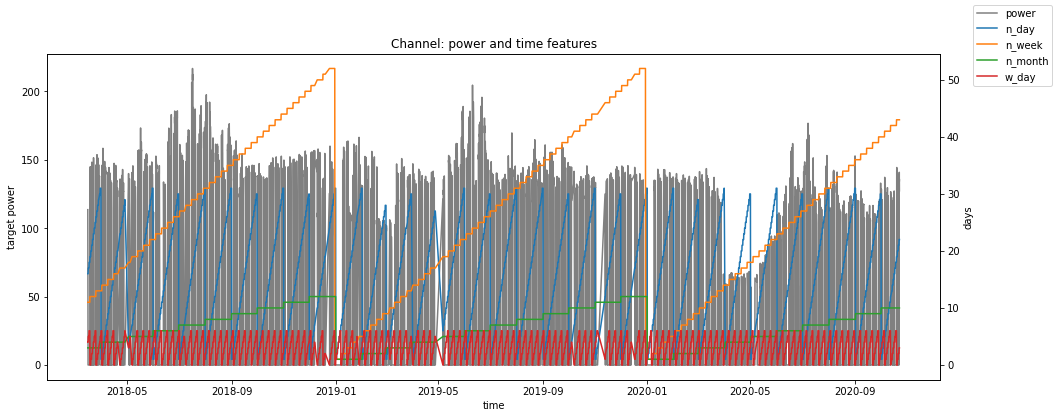

In [43]:
time_col_list = [(df_data_wh['n_day'],'n_day'),
                 (df_data_wh['n_week'],'n_week'),
                 (df_data_wh['n_month'],'n_month'),
                 (df_data_wh['w_day'],'w_day')]

fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.set_xlabel('time')
ax1.set_ylabel('target power')
ax1.plot(df_data_wh['time'].values, df_data_wh['Target_Sum_Complex'].values, label='power', color='grey')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('days')
for col in time_col_list:
    ax2.plot(df_data_wh['time'].values, col[0].values, label=col[1])
ax2.tick_params(axis='y')

fig.legend()
plt.title('Channel: power and time features')
plt.show()

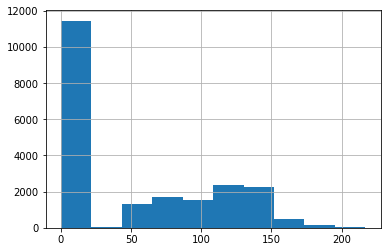

In [50]:
df_data_wh['Target_Sum_Complex'].hist()

Мы построили гистрограмму распределения нагрузки.Больше половины занимает нулевое потребление - это потому что мы занулили выходные,ночные часы и праздничные дни.Если это не брать во внимание, то нагрузка распределена с пиками около 125 в день.График распределения близок к норамальному.

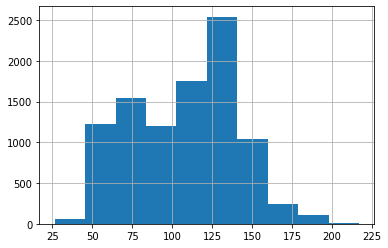

In [54]:
df_data_wh.loc[~(df_data_wh['Target_Sum_Complex']==0)]['Target_Sum_Complex'].hist()

Добавим почасовую температуру в районе Шереметьево.

In [55]:
df_w_sh = pd.read_excel('data/correct_sher.xls',header=6)

In [56]:
df_w_sh = df_w_sh.iloc[:,[0,1]]
df_w_sh.columns = ['time','tC']
df_w_sh['time'] = pd.to_datetime(df_w_sh['time'])
df_w_sh.head(3)

,time,tC
0,2020-10-22 23:30:00,7.0
1,2020-10-22 23:00:00,7.0
2,2020-10-22 22:30:00,7.0


Загрузим данные и оставим только данные с часами которые равны. После этого мы переведем время из Московского в UTC.После всего этого соединим все по столбцу время с исходным данными.Так мы добавим новую фичу время в наш датасет.

In [57]:
#mask_da_1 = np.array((df['time'].dt.hour >= 4) & (df['time'].dt.hour <= 19))
mask_h = np.array((df_w_sh['time'].dt.minute == 0))
df_w_sh_f = df_w_sh[mask_h]
df_w_sh_f = df_w_sh_f.iloc[::-1]
df_w_sh_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22827 entries, 45331 to 1
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    22827 non-null  datetime64[ns]
 1   tC      22825 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 535.0 KB


In [58]:
df_w_sh_f['time'] = df_w_sh_f['time'].dt.tz_localize('Europe/Moscow').dt.tz_convert('UTC')
df_w_sh_f['time'] = df_w_sh_f['time'].dt.tz_localize(None)
df_w_sh_f.head()

,time,tC
45331,2018-03-15 21:00:00,-7.0
45329,2018-03-15 22:00:00,-8.0
45327,2018-03-15 23:00:00,-9.0
45325,2018-03-16 00:00:00,-10.0
45323,2018-03-16 01:00:00,-11.0


In [60]:
df_temp = df.merge(df_w_sh_f,on=['time'])

In [61]:
#df_temp = df_temp.drop(['Temp_C'],axis=1)
df_temp.head(2)

,time,_Accumulator_Bus_1_e_TM1H_mv_val,_Accumulator_Bus_1_e_TM1H_mv_qual,_Accumulator_Bus_1_p_TM1H_mv_qual,_Accumulator_Bus_1_p_TM1H_mv_val,_Accumulator_Bus_1_phaseA_p_TM1H_mv_val,_Accumulator_Bus_1_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_1_phaseB_p_TM1H_mv_val,_Accumulator_Bus_1_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_1_phaseC_p_TM1H_mv_val,_Accumulator_Bus_1_phaseC_p_TM1H_mv_qual,_Accumulator_Bus_2_e_TM1H_mv_val,_Accumulator_Bus_2_e_TM1H_mv_qual,_Accumulator_Bus_2_p_TM1H_mv_qual,_Accumulator_Bus_2_p_TM1H_mv_val,_Accumulator_Bus_2_phaseA_p_TM1H_mv_val,_Accumulator_Bus_2_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_2_phaseB_p_TM1H_mv_val,_Accumulator_Bus_2_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_2_phaseC_p_TM1H_mv_val,_Accumulator_Bus_2_phaseC_p_TM1H_mv_qual,_Accumulator_Bus_3_e_TM1H_mv_val,_Accumulator_Bus_3_e_TM1H_mv_qual,_Accumulator_Bus_3_p_TM1H_mv_qual,_Accumulator_Bus_3_p_TM1H_mv_val,_Accumulator_Bus_3_phaseA_p_TM1H_mv_val,_Accumulator_Bus_3_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_3_phaseB_p_TM1H_mv_val,_Accumulator_Bus_3_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_3_phaseC_p_TM1H_mv_val,_Accumulator_Bus_3_phaseC_p_TM1H_mv_qual,_Accumulator_Bus_4_e_TM1H_mv_val,_Accumulator_Bus_4_e_TM1H_mv_qual,_Accumulator_Bus_4_p_TM1H_mv_val,_Accumulator_Bus_4_p_TM1H_mv_qual,_Accumulator_Bus_4_phaseA_p_TM1H_mv_val,_Accumulator_Bus_4_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_4_phaseB_p_TM1H_mv_val,_Accumulator_Bus_4_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_4_phaseC_p_TM1H_mv_val,_Accumulator_Bus_4_phaseC_p_TM1H_mv_qual,_All_Consumers_p_TM1H_mv_val,_All_Consumers_p_TM1H_mv_qual,_Bus_1_p_TM1H_mv_val,_Bus_1_p_TM1H_mv_qual,_Bus_2_p_TM1H_mv_val,_Bus_2_p_TM1H_mv_qual,_Bus_3_p_TM1H_mv_val,_Bus_3_p_TM1H_mv_qual,_Bus_4_p_TM1H_mv_val,_Bus_4_p_TM1H_mv_qual,_Consumers_Bus_1_p_TM1H_mv_qual,_Consumers_Bus_1_p_TM1H_mv_val,_Consumers_Bus_2_p_TM1H_mv_qual,_Consumers_Bus_2_p_TM1H_mv_val,_Consumers_Bus_3_p_TM1H_mv_qual,_Consumers_Bus_3_p_TM1H_mv_val,_Consumers_Bus_4_p_TM1H_mv_qual,_Consumers_Bus_4_p_TM1H_mv_val,_externalGrid_Bus_1_p_TM1H_mv_qual,_externalGrid_Bus_1_p_TM1H_mv_val,_externalGrid_Bus_1_phaseA_p_TM1H_mv_val,_externalGrid_Bus_1_phaseA_p_TM1H_mv_qual,_externalGrid_Bus_1_phaseB_p_TM1H_mv_val,_externalGrid_Bus_1_phaseB_p_TM1H_mv_qual,_externalGrid_Bus_1_phaseC_p_TM1H_mv_val,_externalGrid_Bus_1_phaseC_p_TM1H_mv_qual,_externalGrid_Bus_2_p_TM1H_mv_qual,_externalGrid_Bus_2_p_TM1H_mv_val,_externalGrid_Bus_2_phaseA_p_TM1H_mv_val,_externalGrid_Bus_2_phaseA_p_TM1H_mv_qual,_externalGrid_Bus_2_phaseB_p_TM1H_mv_val,_externalGrid_Bus_2_phaseB_p_TM1H_mv_qual,_externalGrid_Bus_2_phaseC_p_TM1H_mv_val,_externalGrid_Bus_2_phaseC_p_TM1H_mv_qual,_externalGrid_Bus_3_p_TM1H_mv_qual,_externalGrid_Bus_3_p_TM1H_mv_val,_externalGrid_Bus_3_phaseA_p_TM1H_mv_val,_externalGrid_Bus_3_phaseA_p_TM1H_mv_qual,_externalGrid_Bus_3_phaseB_p_TM1H_mv_val,_externalGrid_Bus_3_phaseB_p_TM1H_mv_qual,_externalGrid_Bus_3_phaseC_p_TM1H_mv_val,_externalGrid_Bus_3_phaseC_p_TM1H_mv_qual,_externalGrid_Bus_4_p_TM1H_mv_qual,_externalGrid_Bus_4_p_TM1H_mv_val,_externalGrid_Bus_4_phaseA_p_TM1H_mv_val,_externalGrid_Bus_4_phaseA_p_TM1H_mv_qual,_externalGrid_Bus_4_phaseB_p_TM1H_mv_val,_externalGrid_Bus_4_phaseB_p_TM1H_mv_qual,_externalGrid_Bus_4_phaseC_p_TM1H_mv_val,_externalGrid_Bus_4_phaseC_p_TM1H_mv_qual,_roof_1_Bus_4_onoff_TM1H_mv_val,_roof_1_Bus_4_onoff_TM1H_mv_qual,_roof_1_Bus_4_p_TM1H_mv_val,_roof_1_Bus_4_p_TM1H_mv_qual,_roof_1_Bus_4_phaseA_p_TM1H_mv_val,_roof_1_Bus_4_phaseA_p_TM1H_mv_qual,_roof_1_Bus_4_phaseB_p_TM1H_mv_val,_roof_1_Bus_4_phaseB_p_TM1H_mv_qual,_roof_1_Bus_4_phaseC_p_TM1H_mv_val,_roof_1_Bus_4_phaseC_p_TM1H_mv_qual,_roof_2_Bus_4_onoff_TM1H_mv_val,_roof_2_Bus_4_onoff_TM1H_mv_qual,_roof_2_Bus_4_p_TM1H_mv_val,_roof_2_Bus_4_p_TM1H_mv_qual,_roof_2_Bus_4_phaseA_p_TM1H_mv_val,_roof_2_Bus_4_phaseA_p_TM1H_mv_qual,_roof_2_Bus_4_phaseB_p_TM1H_mv_val,_roof_2_Bus_4_phaseB_p_TM1H_mv_qual,_roof_2_Bus_4_phaseC_p_TM1H_mv_val,_roof_2_Bus_4_phaseC_p_TM1H_mv_qual,_roof_Bus_1_onoff_TM1H_mv_val,_roof_Bus_1_onoff_TM1H_mv_qual,

Построим гистограмму по времени и увидим, что самое большое число имеет температура около нуля и от 10 до 20 градусов.

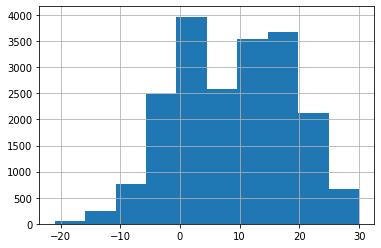

In [62]:
df_temp['tC'].hist()

In [63]:
df = df_temp

In [64]:
df_data_wh = df_temp
df_data_wh.head()

,time,_Accumulator_Bus_1_e_TM1H_mv_val,_Accumulator_Bus_1_e_TM1H_mv_qual,_Accumulator_Bus_1_p_TM1H_mv_qual,_Accumulator_Bus_1_p_TM1H_mv_val,_Accumulator_Bus_1_phaseA_p_TM1H_mv_val,_Accumulator_Bus_1_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_1_phaseB_p_TM1H_mv_val,_Accumulator_Bus_1_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_1_phaseC_p_TM1H_mv_val,_Accumulator_Bus_1_phaseC_p_TM1H_mv_qual,_Accumulator_Bus_2_e_TM1H_mv_val,_Accumulator_Bus_2_e_TM1H_mv_qual,_Accumulator_Bus_2_p_TM1H_mv_qual,_Accumulator_Bus_2_p_TM1H_mv_val,_Accumulator_Bus_2_phaseA_p_TM1H_mv_val,_Accumulator_Bus_2_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_2_phaseB_p_TM1H_mv_val,_Accumulator_Bus_2_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_2_phaseC_p_TM1H_mv_val,_Accumulator_Bus_2_phaseC_p_TM1H_mv_qual,_Accumulator_Bus_3_e_TM1H_mv_val,_Accumulator_Bus_3_e_TM1H_mv_qual,_Accumulator_Bus_3_p_TM1H_mv_qual,_Accumulator_Bus_3_p_TM1H_mv_val,_Accumulator_Bus_3_phaseA_p_TM1H_mv_val,_Accumulator_Bus_3_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_3_phaseB_p_TM1H_mv_val,_Accumulator_Bus_3_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_3_phaseC_p_TM1H_mv_val,_Accumulator_Bus_3_phaseC_p_TM1H_mv_qual,_Accumulator_Bus_4_e_TM1H_mv_val,_Accumulator_Bus_4_e_TM1H_mv_qual,_Accumulator_Bus_4_p_TM1H_mv_val,_Accumulator_Bus_4_p_TM1H_mv_qual,_Accumulator_Bus_4_phaseA_p_TM1H_mv_val,_Accumulator_Bus_4_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_4_phaseB_p_TM1H_mv_val,_Accumulator_Bus_4_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_4_phaseC_p_TM1H_mv_val,_Accumulator_Bus_4_phaseC_p_TM1H_mv_qual,_All_Consumers_p_TM1H_mv_val,_All_Consumers_p_TM1H_mv_qual,_Bus_1_p_TM1H_mv_val,_Bus_1_p_TM1H_mv_qual,_Bus_2_p_TM1H_mv_val,_Bus_2_p_TM1H_mv_qual,_Bus_3_p_TM1H_mv_val,_Bus_3_p_TM1H_mv_qual,_Bus_4_p_TM1H_mv_val,_Bus_4_p_TM1H_mv_qual,_Consumers_Bus_1_p_TM1H_mv_qual,_Consumers_Bus_1_p_TM1H_mv_val,_Consumers_Bus_2_p_TM1H_mv_qual,_Consumers_Bus_2_p_TM1H_mv_val,_Consumers_Bus_3_p_TM1H_mv_qual,_Consumers_Bus_3_p_TM1H_mv_val,_Consumers_Bus_4_p_TM1H_mv_qual,_Consumers_Bus_4_p_TM1H_mv_val,_externalGrid_Bus_1_p_TM1H_mv_qual,_externalGrid_Bus_1_p_TM1H_mv_val,_externalGrid_Bus_1_phaseA_p_TM1H_mv_val,_externalGrid_Bus_1_phaseA_p_TM1H_mv_qual,_externalGrid_Bus_1_phaseB_p_TM1H_mv_val,_externalGrid_Bus_1_phaseB_p_TM1H_mv_qual,_externalGrid_Bus_1_phaseC_p_TM1H_mv_val,_externalGrid_Bus_1_phaseC_p_TM1H_mv_qual,_externalGrid_Bus_2_p_TM1H_mv_qual,_externalGrid_Bus_2_p_TM1H_mv_val,_externalGrid_Bus_2_phaseA_p_TM1H_mv_val,_externalGrid_Bus_2_phaseA_p_TM1H_mv_qual,_externalGrid_Bus_2_phaseB_p_TM1H_mv_val,_externalGrid_Bus_2_phaseB_p_TM1H_mv_qual,_externalGrid_Bus_2_phaseC_p_TM1H_mv_val,_externalGrid_Bus_2_phaseC_p_TM1H_mv_qual,_externalGrid_Bus_3_p_TM1H_mv_qual,_externalGrid_Bus_3_p_TM1H_mv_val,_externalGrid_Bus_3_phaseA_p_TM1H_mv_val,_externalGrid_Bus_3_phaseA_p_TM1H_mv_qual,_externalGrid_Bus_3_phaseB_p_TM1H_mv_val,_externalGrid_Bus_3_phaseB_p_TM1H_mv_qual,_externalGrid_Bus_3_phaseC_p_TM1H_mv_val,_externalGrid_Bus_3_phaseC_p_TM1H_mv_qual,_externalGrid_Bus_4_p_TM1H_mv_qual,_externalGrid_Bus_4_p_TM1H_mv_val,_externalGrid_Bus_4_phaseA_p_TM1H_mv_val,_externalGrid_Bus_4_phaseA_p_TM1H_mv_qual,_externalGrid_Bus_4_phaseB_p_TM1H_mv_val,_externalGrid_Bus_4_phaseB_p_TM1H_mv_qual,_externalGrid_Bus_4_phaseC_p_TM1H_mv_val,_externalGrid_Bus_4_phaseC_p_TM1H_mv_qual,_roof_1_Bus_4_onoff_TM1H_mv_val,_roof_1_Bus_4_onoff_TM1H_mv_qual,_roof_1_Bus_4_p_TM1H_mv_val,_roof_1_Bus_4_p_TM1H_mv_qual,_roof_1_Bus_4_phaseA_p_TM1H_mv_val,_roof_1_Bus_4_phaseA_p_TM1H_mv_qual,_roof_1_Bus_4_phaseB_p_TM1H_mv_val,_roof_1_Bus_4_phaseB_p_TM1H_mv_qual,_roof_1_Bus_4_phaseC_p_TM1H_mv_val,_roof_1_Bus_4_phaseC_p_TM1H_mv_qual,_roof_2_Bus_4_onoff_TM1H_mv_val,_roof_2_Bus_4_onoff_TM1H_mv_qual,_roof_2_Bus_4_p_TM1H_mv_val,_roof_2_Bus_4_p_TM1H_mv_qual,_roof_2_Bus_4_phaseA_p_TM1H_mv_val,_roof_2_Bus_4_phaseA_p_TM1H_mv_qual,_roof_2_Bus_4_phaseB_p_TM1H_mv_val,_roof_2_Bus_4_phaseB_p_TM1H_mv_qual,_roof_2_Bus_4_phaseC_p_TM1H_mv_val,_roof_2_Bus_4_phaseC_p_TM1H_mv_qual,_roof_Bus_1_onoff_TM1H_mv_val,_roof_Bus_1_onoff_TM1H_mv_qual,

Рассмотри отличие Target_Sum от Target_Sum_Complex. В условиях задачи было сказанно что эти два значения одинаковы, просто вычисляются по разным формула. 

In [65]:
two_col_list = ['Target_Sum','Target_Sum_Complex']
target_math_stats(df, two_col_list)

Mean,Median,Min,Max,STD
Target_Sum
50.57172558244399_MEAN
0.0_MEDIAN
0.0_MIN
216.39196566774422_MAX
58.59269920742201_STD
********************
Mean,Median,Min,Max,STD
Target_Sum_Complex
49.85720048053892_MEAN
0.0_MEDIAN
0.0_MIN
216.82325449649863_MAX
57.93997965604174_STD
********************


In [66]:
df_data_wh['Target_Sum'].isna().sum()

12

In [67]:
df_data_wh['Target_Sum_Complex'].isna().sum()

0

Мы видим,что суммарная почасовая нагрузка рассчитанная как сумма неуправляемых нагрузок - Target Sum,оличается от суммы суммарных потреблений минус крыша, плюс накопители на величину около 1%.В далнейшем мы будем использовать 'Target_Sum_Complex' в качестве нашего таргета.

### Будем рассматривать задачу как прогнозирование временных рядов

Эта функция примимает на входе пандас многомерный массив и выдает нам вектор фичеров и таргетов.Вектор фичей зависит от параметра лукбек - насколько назад мы смотрим, то есть мы подаем кусок временного ряда.Вектор таргета насколько вперед мы делаем предсказания в нашей модели.За это отвечает параметр лоок форвард.

In [68]:
def get_dataset(series, col_look, look_back, look_fwd, cols_features):
    X, y = [], []
    for i in range(len(series[:, col_look]) - look_back - look_fwd):
        temp_X = []
        temp_X.append(series[:, col_look][i:(i + look_back)])
        for col in cols_features:
            temp_X.append(series[:, col][(i + look_fwd):(i + look_back + look_fwd)])
        X.append(temp_X)
        y.append(series[:, col_look][(i + look_back):(i + look_back + look_fwd)])
    return np.array(X), np.array(y)

Эта функция разбивает наши вектора фичей и векторов на батчи трейн и тест.Разбивание происходит без утечки будущего в наше предсказание.То есть мы разбиваем ряд на связанные куски не перемешивая их.

In [69]:
def get_train_test(X, y, test_size=.25):
    cut = int((1 - test_size) * len(y))
    X_train, y_train = X[:cut], y[:cut]
    X_test, y_test = X[cut:], y[cut:]
    
    # LSTM feed [samples, time steps, features]
    print('as is:')
    print('\tX train shape:', X_train.shape, '| X test shape:', X_test.shape)
    print('\ty train shape:', y_train.shape, '| y test shape:', y_test.shape)
    print('\nreshaped to LSTM pattern [samples, time steps, features]:')
    X_train = np.array([x.T for x in X_train])
    X_test = np.array([x.T for x in X_test])
    print('\tX train shape:', X_train.shape, '| X test shape:', X_test.shape)
    print('\ty train shape:', y_train.shape, '| y test shape:', y_test.shape)
    
    return X_train, y_train, X_test, y_test

Немного преобразуем наш датафрейм так что бы наш таргет был первой колонкой.

In [71]:
#перемена мест колонок.
col_list = list(df_data_wh.columns)
col_list.remove('Target_Sum_Complex')
col_list.insert(0,'Target_Sum_Complex')
col_list
df_data_wh_n = df_data_wh[col_list]
df_data_wh = df_data_wh_n
df_data_wh.head()

,Target_Sum_Complex,time,_Accumulator_Bus_1_e_TM1H_mv_val,_Accumulator_Bus_1_e_TM1H_mv_qual,_Accumulator_Bus_1_p_TM1H_mv_qual,_Accumulator_Bus_1_p_TM1H_mv_val,_Accumulator_Bus_1_phaseA_p_TM1H_mv_val,_Accumulator_Bus_1_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_1_phaseB_p_TM1H_mv_val,_Accumulator_Bus_1_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_1_phaseC_p_TM1H_mv_val,_Accumulator_Bus_1_phaseC_p_TM1H_mv_qual,_Accumulator_Bus_2_e_TM1H_mv_val,_Accumulator_Bus_2_e_TM1H_mv_qual,_Accumulator_Bus_2_p_TM1H_mv_qual,_Accumulator_Bus_2_p_TM1H_mv_val,_Accumulator_Bus_2_phaseA_p_TM1H_mv_val,_Accumulator_Bus_2_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_2_phaseB_p_TM1H_mv_val,_Accumulator_Bus_2_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_2_phaseC_p_TM1H_mv_val,_Accumulator_Bus_2_phaseC_p_TM1H_mv_qual,_Accumulator_Bus_3_e_TM1H_mv_val,_Accumulator_Bus_3_e_TM1H_mv_qual,_Accumulator_Bus_3_p_TM1H_mv_qual,_Accumulator_Bus_3_p_TM1H_mv_val,_Accumulator_Bus_3_phaseA_p_TM1H_mv_val,_Accumulator_Bus_3_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_3_phaseB_p_TM1H_mv_val,_Accumulator_Bus_3_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_3_phaseC_p_TM1H_mv_val,_Accumulator_Bus_3_phaseC_p_TM1H_mv_qual,_Accumulator_Bus_4_e_TM1H_mv_val,_Accumulator_Bus_4_e_TM1H_mv_qual,_Accumulator_Bus_4_p_TM1H_mv_val,_Accumulator_Bus_4_p_TM1H_mv_qual,_Accumulator_Bus_4_phaseA_p_TM1H_mv_val,_Accumulator_Bus_4_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_4_phaseB_p_TM1H_mv_val,_Accumulator_Bus_4_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_4_phaseC_p_TM1H_mv_val,_Accumulator_Bus_4_phaseC_p_TM1H_mv_qual,_All_Consumers_p_TM1H_mv_val,_All_Consumers_p_TM1H_mv_qual,_Bus_1_p_TM1H_mv_val,_Bus_1_p_TM1H_mv_qual,_Bus_2_p_TM1H_mv_val,_Bus_2_p_TM1H_mv_qual,_Bus_3_p_TM1H_mv_val,_Bus_3_p_TM1H_mv_qual,_Bus_4_p_TM1H_mv_val,_Bus_4_p_TM1H_mv_qual,_Consumers_Bus_1_p_TM1H_mv_qual,_Consumers_Bus_1_p_TM1H_mv_val,_Consumers_Bus_2_p_TM1H_mv_qual,_Consumers_Bus_2_p_TM1H_mv_val,_Consumers_Bus_3_p_TM1H_mv_qual,_Consumers_Bus_3_p_TM1H_mv_val,_Consumers_Bus_4_p_TM1H_mv_qual,_Consumers_Bus_4_p_TM1H_mv_val,_externalGrid_Bus_1_p_TM1H_mv_qual,_externalGrid_Bus_1_p_TM1H_mv_val,_externalGrid_Bus_1_phaseA_p_TM1H_mv_val,_externalGrid_Bus_1_phaseA_p_TM1H_mv_qual,_externalGrid_Bus_1_phaseB_p_TM1H_mv_val,_externalGrid_Bus_1_phaseB_p_TM1H_mv_qual,_externalGrid_Bus_1_phaseC_p_TM1H_mv_val,_externalGrid_Bus_1_phaseC_p_TM1H_mv_qual,_externalGrid_Bus_2_p_TM1H_mv_qual,_externalGrid_Bus_2_p_TM1H_mv_val,_externalGrid_Bus_2_phaseA_p_TM1H_mv_val,_externalGrid_Bus_2_phaseA_p_TM1H_mv_qual,_externalGrid_Bus_2_phaseB_p_TM1H_mv_val,_externalGrid_Bus_2_phaseB_p_TM1H_mv_qual,_externalGrid_Bus_2_phaseC_p_TM1H_mv_val,_externalGrid_Bus_2_phaseC_p_TM1H_mv_qual,_externalGrid_Bus_3_p_TM1H_mv_qual,_externalGrid_Bus_3_p_TM1H_mv_val,_externalGrid_Bus_3_phaseA_p_TM1H_mv_val,_externalGrid_Bus_3_phaseA_p_TM1H_mv_qual,_externalGrid_Bus_3_phaseB_p_TM1H_mv_val,_externalGrid_Bus_3_phaseB_p_TM1H_mv_qual,_externalGrid_Bus_3_phaseC_p_TM1H_mv_val,_externalGrid_Bus_3_phaseC_p_TM1H_mv_qual,_externalGrid_Bus_4_p_TM1H_mv_qual,_externalGrid_Bus_4_p_TM1H_mv_val,_externalGrid_Bus_4_phaseA_p_TM1H_mv_val,_externalGrid_Bus_4_phaseA_p_TM1H_mv_qual,_externalGrid_Bus_4_phaseB_p_TM1H_mv_val,_externalGrid_Bus_4_phaseB_p_TM1H_mv_qual,_externalGrid_Bus_4_phaseC_p_TM1H_mv_val,_externalGrid_Bus_4_phaseC_p_TM1H_mv_qual,_roof_1_Bus_4_onoff_TM1H_mv_val,_roof_1_Bus_4_onoff_TM1H_mv_qual,_roof_1_Bus_4_p_TM1H_mv_val,_roof_1_Bus_4_p_TM1H_mv_qual,_roof_1_Bus_4_phaseA_p_TM1H_mv_val,_roof_1_Bus_4_phaseA_p_TM1H_mv_qual,_roof_1_Bus_4_phaseB_p_TM1H_mv_val,_roof_1_Bus_4_phaseB_p_TM1H_mv_qual,_roof_1_Bus_4_phaseC_p_TM1H_mv_val,_roof_1_Bus_4_phaseC_p_TM1H_mv_qual,_roof_2_Bus_4_onoff_TM1H_mv_val,_roof_2_Bus_4_onoff_TM1H_mv_qual,_roof_2_Bus_4_p_TM1H_mv_val,_roof_2_Bus_4_p_TM1H_mv_qual,_roof_2_Bus_4_phaseA_p_TM1H_mv_val,_roof_2_Bus_4_phaseA_p_TM1H_mv_qual,_roof_2_Bus_4_phaseB_p_TM1H_mv_val,_roof_2_Bus_4_phaseB_p_TM1H_mv_qual,_roof_2_Bus_4_phaseC_p_TM1H_mv_val,_roof_2_Bus_4_phaseC_p_TM1H_mv_qual,_roof_Bus_1_onoff_TM1H_mv_val,_roof_Bus_1_

Далее мы создадим лист с нашими фичами.Мы исключаем признаки верности,пофазовую разбивку.Оставляем только показатели мощности по четырем входам,временные фичи,температуру.На этих фичах мы будем строить нашу модель.

In [72]:
columns_list = df_data_wh.columns
sub_val = 'val'
#targ_val = '_Consumers_Bus'
targ_val = '_e_'
targ_val2 = '_phase'
targ_val3 = 'n_'
val_list = []
for elem in columns_list:
    if (sub_val in elem) and (targ_val not in elem) and (targ_val2 not in elem) or (targ_val3 in elem) or (elem=='tC') or (elem=='Target_Sum_Complex'):
        val_list.append(elem)

In [73]:
val_list

['Target_Sum_Complex',
 '_Accumulator_Bus_1_p_TM1H_mv_val',
 '_Accumulator_Bus_2_p_TM1H_mv_val',
 '_Accumulator_Bus_3_p_TM1H_mv_val',
 '_Accumulator_Bus_4_p_TM1H_mv_val',
 '_All_Consumers_p_TM1H_mv_val',
 '_Bus_1_p_TM1H_mv_val',
 '_Bus_2_p_TM1H_mv_val',
 '_Bus_3_p_TM1H_mv_val',
 '_Bus_4_p_TM1H_mv_val',
 '_Consumers_Bus_1_p_TM1H_mv_val',
 '_Consumers_Bus_2_p_TM1H_mv_val',
 '_Consumers_Bus_3_p_TM1H_mv_val',
 '_Consumers_Bus_4_p_TM1H_mv_val',
 '_externalGrid_Bus_1_p_TM1H_mv_val',
 '_externalGrid_Bus_2_p_TM1H_mv_val',
 '_externalGrid_Bus_3_p_TM1H_mv_val',
 '_externalGrid_Bus_4_p_TM1H_mv_val',
 '_roof_1_Bus_4_onoff_TM1H_mv_val',
 '_roof_1_Bus_4_p_TM1H_mv_val',
 '_roof_2_Bus_4_onoff_TM1H_mv_val',
 '_roof_2_Bus_4_p_TM1H_mv_val',
 '_roof_Bus_1_onoff_TM1H_mv_val',
 '_roof_Bus_1_p_TM1H_mv_val',
 '_unctrl_load_Bus_1_p_TM1H_mv_val',
 '_unctrl_load_Bus_2_p_TM1H_mv_val',
 '_unctrl_load_Bus_3_p_TM1H_mv_val',
 '_unctrl_load_Bus_4_p_TM1H_mv_val',
 'n_day',
 'n_week',
 'n_month',
 'tC']

На основании полученных колонок создаем финальный датафрейм для нашей модели.

In [74]:
#val_list[0] = 'Target_Sum'
channel_sum_huge  = df_data_wh
channel_sum_huge = channel_sum_huge[channel_sum_huge.columns.intersection(val_list)]
#pandas_df = pandas_df[pandas_df.columns.intersection(final_table_columns)]
channel_sum_huge_columns = channel_sum_huge.columns
channel_sum_huge.head()
channel_sum_huge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20114 entries, 0 to 20113
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Target_Sum_Complex                 20114 non-null  float64
 1   _Accumulator_Bus_1_p_TM1H_mv_val   20114 non-null  float64
 2   _Accumulator_Bus_2_p_TM1H_mv_val   20114 non-null  float64
 3   _Accumulator_Bus_3_p_TM1H_mv_val   20114 non-null  float64
 4   _Accumulator_Bus_4_p_TM1H_mv_val   10322 non-null  float64
 5   _All_Consumers_p_TM1H_mv_val       10322 non-null  float64
 6   _Bus_1_p_TM1H_mv_val               20034 non-null  float64
 7   _Bus_2_p_TM1H_mv_val               19974 non-null  float64
 8   _Bus_3_p_TM1H_mv_val               20019 non-null  float64
 9   _Bus_4_p_TM1H_mv_val               19966 non-null  float64
 10  _Consumers_Bus_1_p_TM1H_mv_val     20046 non-null  float64
 11  _Consumers_Bus_2_p_TM1H_mv_val     20046 non-null  flo

In [75]:
df_data_wh['Target_Sum_Complex'].isna().sum()
target_math_stats(df, ['Target_Sum_Complex'])

Mean,Median,Min,Max,STD
Target_Sum_Complex
49.85720048053892_MEAN
0.0_MEDIAN
0.0_MIN
216.82325449649863_MAX
57.93997965604174_STD
********************


Еще раз проверяем нашу целевую переменную все ли с ней в порядке или нет, не изменилась ли она и построим график еще раз.Наша задача проследить что бы данные не были утеряны или изменилась их структура.

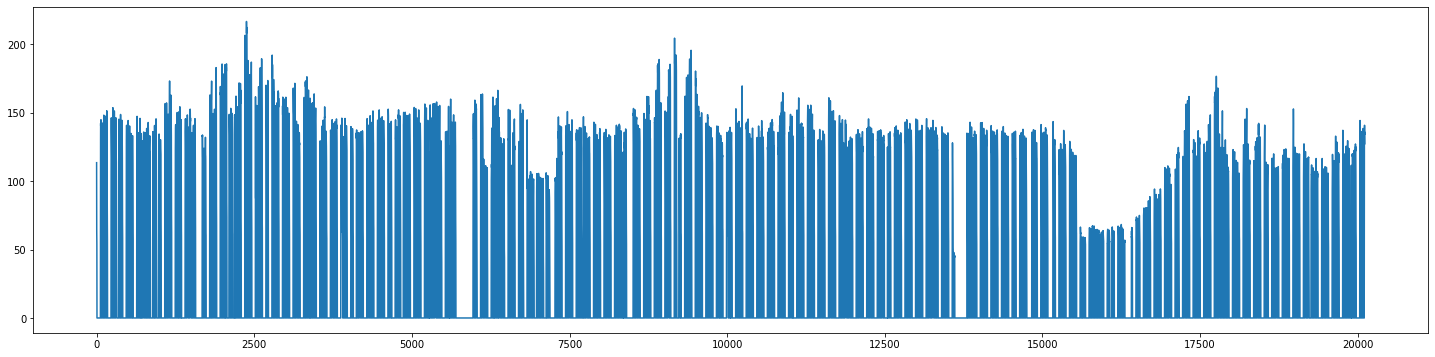

In [76]:
fig = plt.figure(figsize=(25, 6))
ax = plt.axes()
ax.plot(channel_sum_huge.index,channel_sum_huge['Target_Sum_Complex'].values)

Мы оставили категориальные переменные включения и выключения.Сделаем просто оне хот энкодинг и оставим эту категориальную переменную в наших фичах.

In [77]:
channel_sum_huge['_roof_Bus_1_onoff_TM1H_mv_val'] =  channel_sum_huge['_roof_Bus_1_onoff_TM1H_mv_val'].fillna(0)
channel_sum_huge['_roof_2_Bus_4_onoff_TM1H_mv_val'] = channel_sum_huge['_roof_2_Bus_4_onoff_TM1H_mv_val'].fillna(0)
channel_sum_huge['_roof_1_Bus_4_onoff_TM1H_mv_val'] = channel_sum_huge['_roof_1_Bus_4_onoff_TM1H_mv_val'].fillna(0)


channel_sum_huge['_roof_Bus_1_onoff_TM1H_mv_val'] = channel_sum_huge['_roof_Bus_1_onoff_TM1H_mv_val'].eq('ON').mul(1.0)
channel_sum_huge['_roof_Bus_1_onoff_TM1H_mv_val'] = channel_sum_huge['_roof_Bus_1_onoff_TM1H_mv_val'].eq('OFF').mul(0.0)
channel_sum_huge['_roof_2_Bus_4_onoff_TM1H_mv_val'] = channel_sum_huge['_roof_2_Bus_4_onoff_TM1H_mv_val'].eq('ON').mul(1.0)
channel_sum_huge['_roof_2_Bus_4_onoff_TM1H_mv_val'] = channel_sum_huge['_roof_2_Bus_4_onoff_TM1H_mv_val'].eq('OFF').mul(0.0)
channel_sum_huge['_roof_1_Bus_4_onoff_TM1H_mv_val'] = channel_sum_huge['_roof_1_Bus_4_onoff_TM1H_mv_val'].eq('ON').mul(1.0)
channel_sum_huge['_roof_1_Bus_4_onoff_TM1H_mv_val'] = channel_sum_huge['_roof_1_Bus_4_onoff_TM1H_mv_val'].eq('OFF').mul(0.0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [78]:
channel_sum_huge_columns = channel_sum_huge.columns
len(channel_sum_huge_columns)

32

Далее очень важная часть в нашей модели.Мы создаем два МинМакс слейлера что бы отшкалировать наши данные от 0 до 1.После этого мы один скейлер используем для таргета, а другой сейлер для всех фичей.Скейлер для таргета мы записываем в файл - он нам понадобиться для предсказаний.Далее мы превращаем наш датафрейм в пандас аррей с отшкалированными величинами с помощью вызова фит трансформа.На выходе мы получаем многомерный нумпай аррей с отшкалированными величинами для подачи в нейронную сетку.

In [79]:
channel_sum_huge = channel_sum_huge.fillna(0)
scaler_huge,scaler_huge_ts  = MinMaxScaler(feature_range=(0, 1)),MinMaxScaler(feature_range=(0, 1))

scaler_huge_ts.fit(channel_sum_huge['Target_Sum_Complex'].values.reshape(-1, 1))
with open(f'model/scaler_sum_huge.pkl', 'wb') as file:
    pickle.dump(scaler_huge_ts, file)
    
channel_sum_huge_sc = scaler_huge.fit_transform(channel_sum_huge)
print('total elements:', len(channel_sum_huge_sc))
print('one element of channel:', channel_sum_huge_sc[0])

total elements: 20114
one element of channel: [0.52376163 0.50797694 0.49182336 0.51789776 0.         0.
 0.51558161 0.53965503 0.41041613 0.45739497 0.         0.
 0.         0.         0.52984038 0.51740143 0.35495438 0.76874567
 0.         0.75671477 0.         0.58714929 0.         0.79406919
 0.         0.         0.         0.         0.5        0.19607843
 0.18181818 0.23529412]


In [80]:
channel_sum_huge_columns

Index(['Target_Sum_Complex', '_Accumulator_Bus_1_p_TM1H_mv_val',
       '_Accumulator_Bus_2_p_TM1H_mv_val', '_Accumulator_Bus_3_p_TM1H_mv_val',
       '_Accumulator_Bus_4_p_TM1H_mv_val', '_All_Consumers_p_TM1H_mv_val',
       '_Bus_1_p_TM1H_mv_val', '_Bus_2_p_TM1H_mv_val', '_Bus_3_p_TM1H_mv_val',
       '_Bus_4_p_TM1H_mv_val', '_Consumers_Bus_1_p_TM1H_mv_val',
       '_Consumers_Bus_2_p_TM1H_mv_val', '_Consumers_Bus_3_p_TM1H_mv_val',
       '_Consumers_Bus_4_p_TM1H_mv_val', '_externalGrid_Bus_1_p_TM1H_mv_val',
       '_externalGrid_Bus_2_p_TM1H_mv_val',
       '_externalGrid_Bus_3_p_TM1H_mv_val',
       '_externalGrid_Bus_4_p_TM1H_mv_val', '_roof_1_Bus_4_onoff_TM1H_mv_val',
       '_roof_1_Bus_4_p_TM1H_mv_val', '_roof_2_Bus_4_onoff_TM1H_mv_val',
       '_roof_2_Bus_4_p_TM1H_mv_val', '_roof_Bus_1_onoff_TM1H_mv_val',
       '_roof_Bus_1_p_TM1H_mv_val', '_unctrl_load_Bus_1_p_TM1H_mv_val',
       '_unctrl_load_Bus_2_p_TM1H_mv_val', '_unctrl_load_Bus_3_p_TM1H_mv_val',
       '_unctrl_load_B

Фичер лист нумеров колонок в нумпай арее - условных колонок.В фичер листе мы указываем какие фичи мы будем использовать для прогноза.
Лук форвард - переменная на сколько мы будем делать прогноз для нашего таргета.Мы выбрали срок 7 дней почасовой прогноз.
Луе беквард - сколько данных из прошлого временного ряда мы будем использовать мы выбрали срок 14 дней.В конце мы получим вектор фичей и вектор таргетов для нашей модели в отшкалированном виде от 1 до 0.Выведем примеры для визуального осмотра.

In [82]:
feature_list = [1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,20,31] #all
#look_fwd = 14 * 24 # days * hours 
look_fwd = 7 * 24
print('look forward:', look_fwd)
#look_back = 2 * look_fwd 
look_back = 14 * 24
print('look back:', look_back)
X_huge, y_huge = get_dataset(channel_sum_huge_sc, 0, look_back, look_fwd, feature_list)
print('X shape:', X_huge.shape, '| y shape:', y_huge.shape)
print('train sample_X:', X_huge[1][:, 0])
#print('train sample_y:', y_huge[0])

look forward: 168
look back: 336
X shape: (19610, 31, 336) | y shape: (19610, 168)
train sample_X: [0.31543849 0.50810469 0.49195657 0.51806387 0.         0.25101535
 0.32422871 0.36630768 0.43169833 0.25101535 0.32422871 0.36630768
 0.43169833 0.30752123 0.31085858 0.31680655 0.76410263 0.
 0.75579376 0.         0.67551068 0.         0.85819892 0.
 0.         0.         0.         0.73333333 0.21568627 0.
 0.41176471]


Разделим на трейн,тест выборку из расчета 80 на трейн и 20 на тест. По хорошему надо было использовать к-фолд разбиения не хватило времени.

In [83]:
X_train, y_train, X_test, y_test = get_train_test(X_huge, y_huge, test_size=.2)

as is:
	X train shape: (15688, 31, 336) | X test shape: (3922, 31, 336)
	y train shape: (15688, 168) | y test shape: (3922, 168)

reshaped to LSTM pattern [samples, time steps, features]:
	X train shape: (15688, 336, 31) | X test shape: (3922, 336, 31)
	y train shape: (15688, 168) | y test shape: (3922, 168)


Мы будем использовать нейронные сети на Керасе.В качестве функции потерь мы будем использовать RMSE - мы пропишем эту функцию кастом.Мы используем многослойные сети LSTM и GRU.Лучшие результаты дала GRU c RMSEProp оптимайзером.Активация лучше была - релу, а не линейная.

In [84]:

from tensorflow.keras.layers import GRU

from tensorflow.keras.metrics import RootMeanSquaredError as RMSE
def root_mean_squared_error_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.math.squared_difference(y_true, y_pred)))



In [85]:
def get_model2(units, n_features, 
              dropout, r_dropout,
              look_back, look_fwd,
              stack=False, loss=root_mean_squared_error_loss):
    model = Sequential()
    if stack:
        model.add(LSTM(units=units, 
                       input_shape=(look_back, n_features), 
                       return_sequences=True, 
                       dropout=dropout, 
                       recurrent_dropout=r_dropout))
        #model.add(BatchNormalization())
        model.add(LSTM(units=units,
                       dropout=dropout, 
                       recurrent_dropout=r_dropout)),
    else:
        model.add(LSTM(units=units, 
                       input_shape=(look_back, n_features),
                       dropout=dropout, 
                       recurrent_dropout=r_dropout))
    model.add(Dense(look_fwd))
    #model.add(Activation('linear'))
    model.add(Activation('relu'))
    adam = optimizers.Adam(lr=.001, clipvalue=.5, clipnorm=1)
    model.compile(loss=loss, optimizer=adam)
    return model
  
def get_model3(units, n_features, 
              dropout, r_dropout,
              look_back, look_fwd,
              stack=False, loss=root_mean_squared_error_loss):
    model = Sequential()
    if stack:
        model.add(GRU(units=units, 
                       input_shape=(look_back, n_features), 
                       return_sequences=True, 
                       dropout=dropout, 
                       recurrent_dropout=r_dropout))
        model.add(BatchNormalization())
        model.add(GRU(units=units,
                       dropout=dropout, 
                       recurrent_dropout=r_dropout)),
    else:
        model.add(GRU(units=units, 
                       input_shape=(look_back, n_features),
                       dropout=dropout, 
                       recurrent_dropout=r_dropout))
    model.add(Dense(look_fwd))
    #model.add(Activation('linear'))
    model.add(Activation('relu'))
    adam = optimizers.Adam(lr=.001, clipvalue=.5, clipnorm=1)
    rms = optimizers.RMSprop(lr=.001, clipvalue=.5, clipnorm=1)
    model.compile(loss=loss, optimizer=rms)
    return model

Использовали каллбеки в нашем тренинге.Остановка трейнинга после 40 эпох если нет прогресса и лосс не падает.
Шедулер уменьшает лернинг рейт если нет снижения ошибки на валидации в течение 20 эпох.
Чекпоинт записывает в файл веса нашей модели при снижении лоса к конце эпохи.

In [86]:
%%time
checkpoint_path = f'model/model_512_31_rms_gru_rmse.hdf5'
earlystopper = EarlyStopping(
    monitor='val_loss', 
    patience=40, 
    verbose=1,
    mode='min'
)
lrreducer = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=.1, 
    patience=20, 
    verbose=1, 
    min_lr=1e-6,
    mode='min'
)
checkpointer = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True,
    save_weights_only=True, 
    mode='min'
)
callbacks = [earlystopper, checkpointer, lrreducer]

CPU times: user 82 µs, sys: 3 µs, total: 85 µs
Wall time: 89.9 µs


Объявляем модель сколько унитов в слоях,сколько фичей в моделях,какой дропаут как регуляризацию выбрать,какую функцию потерь выбрать.
Мы выбрали 512 юнитов в слою - это уменьшило нашу ошибку, фичей у нас 31, функция ошибки кастомная RMSE.Закоментированна строка которая позволяет доучивать нашу модель, загружая ее веса.Если мы не хотим тренировать ее с 0.Наша модель имеет более 900к параметров.Если бы мы выбрали 256 юнитов в слое, то было бы 300к параметров.

In [87]:
model = get_model3(
    units=512, 
    n_features=31, 
    dropout=.5,
    r_dropout=0,
    look_back=look_back, 
    look_fwd=look_fwd,
    stack=False, 
    loss=root_mean_squared_error_loss
)
model.summary()
#model.load_weights('model/model_256_31_rmse_gru_rmse.hdf5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 512)               837120    
_________________________________________________________________
dense (Dense)                (None, 168)               86184     
_________________________________________________________________
activation (Activation)      (None, 168)               0         
Total params: 923,304
Trainable params: 923,304
Non-trainable params: 0
_________________________________________________________________


Начинаем обучение, сделаем 1к эпох - у нас будут работать коллбеки и модель не будет учиться такое большое количество времени.Размер батчк 256.

In [88]:
history = model.fit(
    X_train, y_train, 
    epochs=1000, 
    batch_size=256, 
    validation_data=(X_test, y_test), 
    verbose=1,
    callbacks=callbacks,
    shuffle=False
)

Epoch 1/1000
62/62 [==============================] - ETA: 0s - loss: 0.2584WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0115s vs `on_test_batch_end` time: 0.0465s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.19748, saving model to model/model_256_31_rms_gru_rmse.hdf5
62/62 [==============================] - 12s 187ms/step - loss: 0.2584 - val_loss: 0.1975
Epoch 2/1000
62/62 [==============================] - ETA: 0s - loss: 0.2376
Epoch 00002: val_loss improved from 0.19748 to 0.18650, saving model to model/model_256_31_rms_gru_rmse.hdf5
62/62 [==============================] - 12s 186ms/step - loss: 0.2376 - val_loss: 0.1865
Epoch 3/1000
62/62 [==============================] - ETA: 0s - loss: 0.2230
Epoch 00003: val_loss improved from 0.18650 to 0.16515, saving model to model/model_256_31_rms_gru_rmse.hdf5
62/62 [==============================] - 12s 188ms/step - loss: 0.2230 - val_loss: 0.1652
Epo

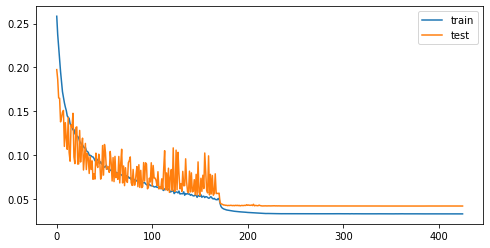

In [89]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Это график обучения нашей модели.Обучение было 400 эпох пока ошибка перестала уменьшаться.

Построим график на перво векторе фичей X_тест.Это недельное предсказание с изображением реального значения и предикта.Мы видим насколько хорошо или плохо сработала наша модель.

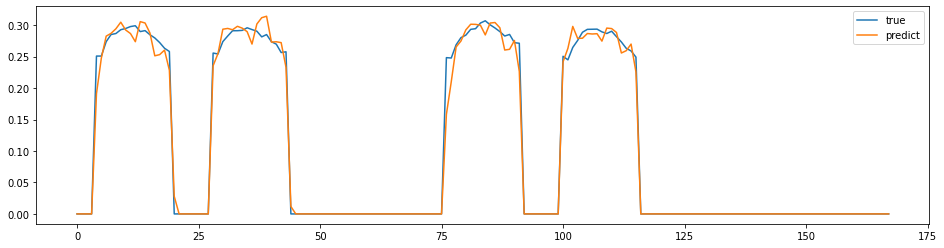

In [90]:
plt.figure(figsize=(16, 4))
y_pred = model.predict(X_test[0:1])[0]
plt.plot(y_test[0], label='true')
plt.plot(y_pred, label='predict')
plt.legend()
plt.show()

Нарисуем график того что было до момента предсказания и когда мыстрали пресказывать.

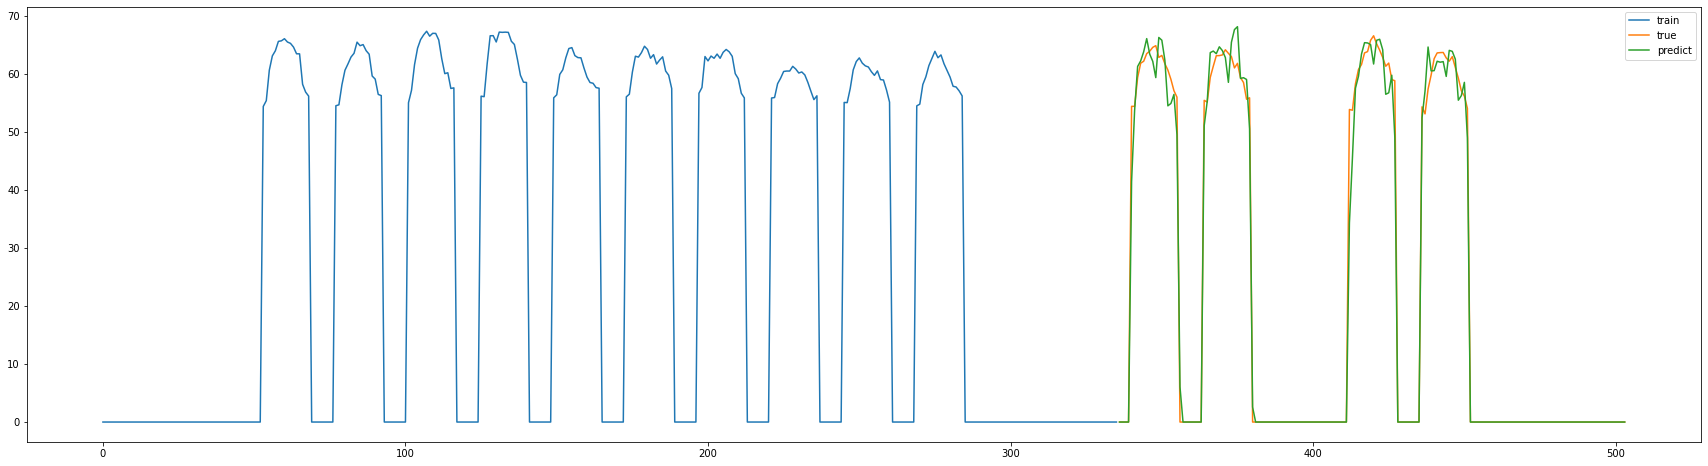

In [91]:
y_pred = model.predict(X_test[0:1])[0]

with open(f'model/scaler_sum_huge.pkl', 'rb') as f:
    scaler_pwr = pickle.load(f)

plt.figure(figsize=(30, 8))
past = range(len(X_train[0][:, 0]))
future = range(len(X_train[0][:, 0]), len(X_train[0][:, 0]) + len(y_test[0]))
plt.plot(past, 
         scaler_pwr.inverse_transform(X_train[-1][:, 0].reshape(-1, 1)), 
         label='train')
plt.plot(future, 
         scaler_pwr.inverse_transform(y_test[0].reshape(-1, 1)), 
         label='true')
plt.plot(future, 
         scaler_pwr.inverse_transform(y_pred.reshape(-1, 1)), 
         label='predict')
plt.legend()
plt.show()

Напишем функцию которая будет считать нам средние ошибки пресдказания за 30 дней на основе наших тестовых таргетов.Мы выводим ошибку МСЕ и РМСЕ.Мы берем нашу тестовую выборку и первые 30 дней.Ошибка считается на 30 векторах по одному дню.Мы считаем предикты и получаем предикты на шкалированных данных - без обатного шкалирования.

In [92]:
def error_30():
  fin = int(y_test.shape[0] / 24.0)
  mse_list = []
  rmse_list = []
  for elem in range(0,fin):
    y_test_truth = y_test[elem:elem+1][0]

    #RELU activations. 256 net. 256 batch - 14 days forward - 14 backward - 32 params *1.3 - 15% test
    y_pred = model.predict(X_test[elem:elem+1])[0]

    mse = mean_squared_error(y_test_truth, y_pred)
    rmse = sqrt(mean_squared_error(y_test_truth, y_pred))
    mse_list.append(mse)
    rmse_list.append(rmse)

  mse_mean = sum(mse_list) / len(mse_list) 
  rmse_mean = sum(rmse_list) / len(rmse_list) 

  print('MSE_MEAN_30_days ',mse_mean)
  print('RMSE_MEAN_30_days',rmse_mean)


Применим нашу функцию расчета средней ошибки, видим что лучше показывают себя GRU юниты в рекурентной модели с функцией ошибки  RMSE.Ошибка RMSE на недельном предсказании по часам составляет 2-4%.Эта ошибка чистого предсказания без постпроцессинга предсказаний - в котором мы заменим нулями ночь,выходные и праздничные часы.Это уменьшит нашу ошибку.

In [149]:
#GRU_RMS_MSE
error_30()

MSE_MEAN_30_days  0.0011429807567914561
RMSE_MEAN_30_days 0.0333568681763385


In [169]:
#LSTM_ADAM_RMSE
error_30() 

MSE_MEAN_30_days  0.0019444130081508193
RMSE_MEAN_30_days 0.04383175066039186


In [141]:
#GRU_RMS_RMSE
error_30()

MSE_MEAN_30_days  0.0008911596763878027
RMSE_MEAN_30_days 0.029147576430292456


In [180]:
#GRU_RMS_RMSE
#512 batch.
#'model/model_256_31_rms_gru_rmse.hdf5'
error_30()

MSE_MEAN_30_days  0.0007698143042018488
RMSE_MEAN_30_days 0.026775659746155756


In [93]:
#GRU_RMS_RMSE_512_units
#'model/model_256_31_rms_gru_rmse.hdf5'
error_30()

MSE_MEAN_30_days  0.00047354776915542956
RMSE_MEAN_30_days 0.020884164500549647


### Создание новой модели и загрузка весов и предикт.

Загрузим нашу модель с нуля и сделаем предсказания с холодного старта.Мы будем использовать уже подготовленные дынне после препроцессинга. X_test,y_test будет уже готов из предыдущего фрагмента.

In [94]:
#Test Interf
from tensorflow.keras.layers import GRU
from tensorflow.keras.metrics import RootMeanSquaredError as RMSE

def root_mean_squared_error_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.math.squared_difference(y_true, y_pred)))


Создаем архитектуру модели и загружаем веса модели.

In [96]:
def get_model_t(units, n_features, 
              dropout, r_dropout,
              look_back, look_fwd,
              stack=False, loss=root_mean_squared_error_loss):
    model = Sequential()
    if stack:
        model.add(GRU(units=units, 
                       input_shape=(look_back, n_features), 
                       return_sequences=True, 
                       dropout=dropout, 
                       recurrent_dropout=r_dropout))
        model.add(BatchNormalization())
        model.add(GRU(units=units,
                       dropout=dropout, 
                       recurrent_dropout=r_dropout)),
    else:
        model.add(GRU(units=units, 
                       input_shape=(look_back, n_features),
                       dropout=dropout, 
                       recurrent_dropout=r_dropout))
    model.add(Dense(look_fwd))
    #model.add(Activation('linear'))
    model.add(Activation('relu'))
    adam = optimizers.Adam(lr=.001, clipvalue=.5, clipnorm=1)
    rms = optimizers.RMSprop(lr=.001, clipvalue=.5, clipnorm=1)
    model.compile(loss=loss, optimizer=rms)
    return model

model_t = get_model_t(
    units=512, 
    n_features=31, 
    dropout=.4,
    r_dropout=0,
    look_back=look_back, 
    look_fwd=look_fwd,
    stack=False, 
    loss=root_mean_squared_error_loss
)
    
model_t.summary()
model_t.load_weights('model/model_256_31_rms_gru_rmse.hdf5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 512)               837120    
_________________________________________________________________
dense_2 (Dense)              (None, 168)               86184     
_________________________________________________________________
activation_2 (Activation)    (None, 168)               0         
Total params: 923,304
Trainable params: 923,304
Non-trainable params: 0
_________________________________________________________________


Создадим лист с предсказаниями.Важно ометить что лист содержит значения после обратного применения скейлера.То есть это реальные значения.

In [97]:
#model_t.predict(X_test[0:1])[0]

y_pred_t = model_t.predict(X_test[0:1])[0]
with open(f'model/scaler_sum_huge.pkl', 'rb') as f:
    scaler_pwr = pickle.load(f)
#print(scaler_pwr.inverse_transform(y_pred_t.reshape(-1, 1)))
pred_list = scaler_pwr.inverse_transform(y_pred_t.reshape(-1, 1))

Знакомая нам функция подсчета средней ошибки на 30 днях, но уже на свежей модели без тренировки, а только с загруженными параметрами.

In [98]:
#MODEL AFTER TRAINING

def error_30_t():
  fin = int(y_test.shape[0] / 24.0)
  mse_list = []
  rmse_list = []
  for elem in range(0,fin):
    y_test_truth = y_test[elem:elem+1][0]

    #RELU activations. 256 net. 256 batch - 14 days forward - 14 backward - 32 params *1.3 - 15% test
    y_pred = model_t.predict(X_test[elem:elem+1])[0]

    mse = mean_squared_error(y_test_truth, y_pred)
    rmse = sqrt(mean_squared_error(y_test_truth, y_pred))
    mse_list.append(mse)
    rmse_list.append(rmse)

  mse_mean = sum(mse_list) / len(mse_list) 
  rmse_mean = sum(rmse_list) / len(rmse_list) 

  print('MSE_MEAN_30_days ',mse_mean)
  print('RMSE_MEAN_30_days',rmse_mean)



Мы видим что ошибка осталась такйо же 2%.

In [99]:
error_30_t()

MSE_MEAN_30_days  0.00047324306896200097
RMSE_MEAN_30_days 0.020881002808403694


Дальше создадим датафрейм с предсказаниями и временем.Создадим лист с правдимыми занчениями - это y_test просто отшкалированный обратно. 
Функция поиска индексов ищет в исходном датафрейме индексы строки по значению таргет переменной.На выходе мы получаем лист с индексами которые соответсвуют нашим правдивым значениям.Далее мы созадем лист в котором стоят значения времени в соответсвии с данными индексами.

In [100]:
y_pred_t = model_t.predict(X_test[0:1])[0]
with open(f'model/scaler_sum_huge.pkl', 'rb') as f:
    scaler_pwr = pickle.load(f)
pred_list = scaler_pwr.inverse_transform(y_pred_t.reshape(-1, 1))
y_test_truth = y_test[0:1][0]


truth = scaler_pwr.inverse_transform(y_test_truth.reshape(-1,1))
truth_list = truth[:,0]



def index_lister(truth_list):
  counter = 0
  for elem in truth_list:
    true_index_list = []
    if elem == 0:
      counter += 1
    elif elem > 0:
      try:
        index = df_data_wh.loc[df_data_wh.isin([elem]).any(axis=1)].index[0]
        #index_r = index + (len(truth_list) - counter)
        start = int(index)-counter
        finish = start + len(truth_list)
        true_index_list = list(range(start,finish))
        #print(df_data_wh.iloc[index]['time'])
        return true_index_list
        break
      except Exception:
        counter += 1
        continue

res_index_list = index_lister(truth_list)
time_list = []

for elem in res_index_list:
  time_list.append(df_data_wh.iloc[elem]['time'])

После этого мы объединям листы со временем, реальными значениями и предсказаниями.Выводим финальный датафрейм.

In [101]:
res_df = pd.DataFrame({'Time':time_list,'Real_Value':truth[:,0],'Predicted_value':pred_list[:,0]})
res_df.head(5)

,Time,Real_Value,Predicted_value
0,2020-04-20 00:00:00,0.000000,0.000000
1,2020-04-20 01:00:00,0.000000,0.000000
2,2020-04-20 02:00:00,0.000000,0.000000
3,2020-04-20 03:00:00,0.000000,0.000000
4,2020-04-20 04:00:00,54.400695,41.313389


Подсчитаем ошибку RMSE на нашем недельном предсказании.Она будет 2.86%

In [102]:
pred_rmse = sqrt(mean_squared_error(res_df['Real_Value'], res_df['Predicted_value']))
print('RMSE before postprocessing for the week hourly prediction',pred_rmse)

RMSE before postprocessing for the week hourly prediction 2.8586957760217926


Применим поспроцессинг предсказаний.Он будет заключаться в занулении празников,выходных,и ночьных часов в предсказаниях нашей модели.
Мы получаем чуть улучшенный датафрейм.

In [103]:
#Postprocessing predictions.
#Заполним нулями выходные,ночные,праздники для повышения точности предскзания.

mask_pr_1 = np.array((res_df['Time'].dt.hour >= 4) & (res_df['Time'].dt.hour <= 19))
mask_pr_2 = np.array((res_df['Time'].dt.weekday < 5 ))
mask_pr_3 = ~np.in1d(res_df['Time'].dt.date, pd.to_datetime(cel_day_18).date)
mask_pr_4 = ~np.in1d(res_df['Time'].dt.date, pd.to_datetime(cel_day_19).date)
mask_pr_5 = ~np.in1d(res_df['Time'].dt.date, pd.to_datetime(cel_day_20).date)
mask_pr_6 = ~np.in1d(res_df['Time'].dt.date, pd.to_datetime(cel_day_21).date)


res_df['Predicted_value'] = np.where(mask_pr_1&mask_pr_2&mask_pr_3&mask_pr_4&mask_pr_5,res_df['Predicted_value'],0)
res_df.head()

,Time,Real_Value,Predicted_value
0,2020-04-20 00:00:00,0.000000,0.000000
1,2020-04-20 01:00:00,0.000000,0.000000
2,2020-04-20 02:00:00,0.000000,0.000000
3,2020-04-20 03:00:00,0.000000,0.000000
4,2020-04-20 04:00:00,54.400695,41.313389


Подсчитаем ошибку и видим что ошибка немного уменьшилась в 2.86 до 2.81. 

In [104]:

final_rmse = sqrt(mean_squared_error(res_df['Real_Value'], res_df['Predicted_value']))
print('Final RMSE after postprocessing for the week hourly prediction',final_rmse)

Final RMSE after postprocessing for the week hourly prediction 2.8109480435289447


Эта ошибка на предсказании недели с часовым интервалом. 
Объем GPU памяти при тренировке был где то 7-8 ГБ.

Интерфейс сдачи модели. ИНТЕРФЕЙС НЕ РЕАЛИЗОВАН!

In [ ]:
def dumb_forecaster(dt, col, df):
    res = df.loc[dt - datetime.timedelta(hours=24): (dt - datetime.timedelta(hours=24)).replace(hour=23), col]#.values
    res.index = [idx + datetime.timedelta(days=1) for idx in res.index]
    return res.index, res.values

def preprocess(fname, hourly=True):
    df = pd.read_excel(fname).set_index('time')
    if hourly and len(df) > 0:
        df = df.reindex(pd.date_range(df.index[0], df.index[-1], freq='H'))
    return df

In [ ]:
def fit(fname, fname_meters):
    df = preprocess(fname)
    df_met = preprocess(fname_meters, hourly=False)
    
    with open('model.pickle', 'wb') as f:
        pickle.dump((dumb_forecaster, df, df_met), f)

def predict(dt, extra_data='upd.xlsx', extra_data_meters='upd_met.xlsx'):
    df_upd = preprocess(extra_data)
    df_upd_met = preprocess(extra_data_meters)
    with open('model.pickle', 'rb') as f:
        dumb_forecaster, df, df_met = pickle.load(f)
    df = df.append(df_upd)
    idx, res = dumb_forecaster(dt, [f'_unctrl_load_Bus_{i}_p_TM1H_mv_val' for i in range(1,5)], df)
    
    return pd.DataFrame(index=idx, data={'val': res.sum(axis=1)})

In [ ]:
fit(fname='data/example_data.xlsx', fname_meters='data/example_data_meters.xlsx')

In [ ]:
initial_date = pd.to_datetime('2020-10-22 10:00:00')
# for delta in range(4):
#     upd = f'example_{delta}.xlsx'
#     upd_met = f'example_met_{delta}.xlsx'
#     result = predict(initial_date + datetime.timedelta(hours=delta), upd, upd_met)
#     print(result)

In [ ]:
import datetime

In [ ]:
for delta in range(4):
    upd = f'data/example_{delta}.xlsx'
    upd_met = f'data/example_met_{delta}.xlsx'
    result = predict(initial_date + datetime.timedelta(hours=delta), upd, upd_met)
    print(result)

                            val
2020-10-22 10:00:00  138.599030
2020-10-22 11:00:00  134.549665
2020-10-22 12:00:00  131.756199
2020-10-22 13:00:00  118.690551
2020-10-22 14:00:00  110.248142
2020-10-22 15:00:00   97.128128
2020-10-22 16:00:00   77.905313
2020-10-22 17:00:00   70.844990
2020-10-22 18:00:00   65.221233
2020-10-22 19:00:00   58.935559
2020-10-22 20:00:00   56.115262
2020-10-22 21:00:00   56.779625
2020-10-22 22:00:00   56.230875
2020-10-22 23:00:00   56.424949
                            val
2020-10-22 11:00:00  134.549665
2020-10-22 12:00:00  131.756199
2020-10-22 13:00:00  118.690551
2020-10-22 14:00:00  110.248142
2020-10-22 15:00:00   97.128128
2020-10-22 16:00:00   77.905313
2020-10-22 17:00:00   70.844990
2020-10-22 18:00:00   65.221233
2020-10-22 19:00:00   58.935559
2020-10-22 20:00:00   56.115262
2020-10-22 21:00:00   56.779625
2020-10-22 22:00:00   56.230875
2020-10-22 23:00:00   56.424949
                            val
2020-10-22 12:00:00  131.756199
2020-10-